In [4]:
# Install Libraries.
!pip install selenium
!pip install bs4

In [6]:
!pip install pandas

^C
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.8 MB 495.5 kB/s eta 0:00:22
   ---------------------------------------- 0.1/10.8 MB 655.4 kB/s eta 0:00:17
    --------------------------------------- 0.2/10.8 MB 1.3 MB/s eta 0:00:09
   --- ------------------------------------ 0.8/10.8 MB 3.8 MB/s eta 0:00:03
   -------- ------------------------------- 2.2/10.8 MB 8.2 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/10.8 MB 8.7 MB/s eta 0:00:01
   ----------- ---------------------------- 3.1/10.8 MB 9.1 MB/s eta 0:00:01
   --------------- ------------------------ 4.2/10.8 MB 10.3 MB/s eta 0:00:01
   -------------------- ------------------- 5.6/10.8 MB 12.3 MB/s eta 0:00:01
   ------------------------- -------------- 6.8/10.8 MB 13.6 MB/s eta 0:00:01
   ---------------------------- ----------- 7.8/10.8 MB 14.7 MB/s eta 0:00:01
  

In [1]:
# Load Libraries.
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import pandas as pd
from datetime import datetime as dt
import time as t
import os
import re
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementNotInteractableException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from urllib.parse import urljoin

In [123]:
# Initialization. The URL we begin with, incognito mode, maximised browser window, initiation of the driver 
# and the creation of the tool SOUP for locating the information we look for
options = Options()
options.add_argument('--incognito')
options.add_argument('start-maximized')
driver = webdriver.Chrome(options = options)
driver.get("https://www.********.dk/en/**********************/")
t.sleep(5)
html = driver.page_source
soup = bs(html, features = "html.parser")


# The base url needed for updating the driver regarding the URL changes. 
base = "https://www.*******.dk"


# The information we aim to collect 
Areas = []
Sub_title = []
extra_info_list = ["Property type","Furnished","Shareable","Elevator","Balcony","Parking","Dishwasher","Washing machine",
                   "Dryer", "Deposit", "Creation Date","Move-in price", "Utilities", "Rental period", "Size", "Rooms",
                   "Monthly net rent", "Areas", "Sub_title", "Pets allowed", "Senior friendly"]


# We collect all the data in a dictionary both for efficiency and reasons of convenience.
empty_dict = {}
for name in extra_info_list:
    empty_dict[name] = []


# A function to eliminate the cookie window appearing when entering the webpage for the very first time
def click_cookie(driver, xpath):
    try:
        driver.find_element(By.XPATH, xpath)
    except NoSuchElementException:
        return False
    return True

# A function to eliminate the search agent window appearing when entering the webpage for the very first time.
def click_search_agent(driver, xpath):
    try:
        driver.find_element(By.XPATH, xpath)
    except NoSuchElementException:
        return False
    return True

# Clicking "Decline All" on the cookie preferences window
if click_cookie(driver,"//*[@id='declineButton']"):
    element = driver.find_element(By.XPATH,"//*[@id='declineButton']")
    driver.execute_script('arguments[0].scrollIntoView();', element)
    driver.execute_script('window.scrollBy(0,-200);')
    element.click()
else:
    print('No cookie preferences window')

# Closing the Search Agent window.
if click_search_agent(driver,"//*[@id='radix-:R96q:']/button"):
    element = driver.find_element(By.XPATH,"//*[@id='radix-:R96q:']/button")
    driver.execute_script('arguments[0].scrollIntoView();', element)
    driver.execute_script('window.scrollBy(0,-200);')
    element.click()
else:
    print('No search agent window')

# Roaming all pagination links by firstly checking the existence of the "Next" button 
# and then clicking it if exists, or if not, terminating the process. 
def find_pagelink(driver, xpath):
    try:
        driver.find_element(By.XPATH, xpath)
    except NoSuchElementException:
        return False
    return True

# Index used for not repeating the info collection from the promoted ads
# (in Incognito mode the ads do not change)
i = 1

# The loop populating the dictionary with all the entries available on BoligPortal.
while find_pagelink(driver,"//*[@id='app']/div[1]/div/div[1]/div/div/div[2]/div[9]/div/div/button[2]"):
    
    if i == 1:
        listings = soup.find_all("div", class_="css-krvsu4")
    else:
        listings = soup.find_all("div", class_="css-krvsu4")
        listings = listings[3:]# We ignore the first 3 promoted entries from the second pagination link onwards.

    for listing in listings:
        link = listing.find("a", href = True)
        if link :
            rel_href = link["href"]
            href = urljoin(base, rel_href)
            while True:
                try:
                    # Try to navigate to the URL using the WebDriver
                    driver.get(href)
                    t.sleep(2)  # Sleep after successful navigation
                    break  # Exit the loop if successful
                
                except WebDriverException as e:
                    print(f"Error occurred while trying to get {href}: {e}")
                    print("Retrying...")
                    t.sleep(5)  # Wait before retrying
            #driver.get(href)
            #t.sleep(2) 
            listing_html = driver.page_source
            listing_soup = bs(listing_html, 'html.parser')
            #utilities.append(listing_soup.find("span", class_ = "css-14bctuo").text.strip())
            #move_in.append(listing_soup.find("div", class_ = "css-x1kcbm").find("span", class_ = "css-14bctuo").text.strip())
            empty_dict["Sub_title"].append(listing_soup.find('h3', class_ = "css-1o5zkyw").text.strip())
            empty_dict["Areas"].append(listing_soup.find("div", class_ = "css-1gjufnd").find(class_ = "css-o9y6d5").text.strip())
            boxes = listing_soup.find_all("div", class_ = "css-1n6wxiw")# All the rows of information after you click a listing
            for box in boxes:
                text = box.find("span", class_ = "css-1td16zm").text.strip()# One-by-one all the types of information within these rows for each listing.
                if text in extra_info_list:
                    value = box.find("span", class_ = "css-1f8murc").text.strip()
                    empty_dict[text].append(value)
            if (len(empty_dict["Utilities"]) < len(empty_dict[extra_info_list[0]])):
                empty_dict["Utilities"].append(0)
            
        #for text in texts:
                 #   if (box.find("span", class_ = "css-1td16zm").text.strip() == text.text.strip()) & (text.text.strip() in extra_info_list):
                  #      value = box.find("span", class_ = "css-1f8murc").text.strip()
                        #empty_dict[text.text.strip()].append(value)
                   #     print(box)
            #ks = listing_soup.find_all("div", class_ = "css-hqz8ri")
            #for k in ks:
             #   l = k.find_all("span", class_ = "css-14bctuo")
              #  move_in.append(l[1].text.strip()) 
               # utilities.append(l[0].text.strip())
                #rental_period.append(l[2].text.strip())
        driver.back()
        t.sleep(2)  # Let the page reload
        html = driver.page_source
        soup = bs(html, 'html.parser')  # Update soup after returning from the listing
        
    # When the collection from listing ends and we go back to the list of listings, the search agent window may appear, hence we need to 
    # shut it down in the following fashion.
    if click_search_agent(driver,"//*[@id='radix-:R96q:']/button"):
        element = driver.find_element(By.XPATH,"//*[@id='radix-:R96q:']/button")
        driver.execute_script('arguments[0].scrollIntoView();', element)
        driver.execute_script('window.scrollBy(0,-200);')
        element.click()
        
        
    # Move to the NEXT page after collecting the information from the previous one.
    element = driver.find_element(By.XPATH,"//*[@id='app']/div[1]/div/div[1]/div/div/div[2]/div[9]/div/div/button[2]")# Find the 'NEXT' button
    driver.execute_script('arguments[0].scrollIntoView();', element)# Scroll over it.
    driver.execute_script('window.scrollBy(0,-200);')
    element.click()

    # Let the page load and inform your driver about the new url.
    t.sleep(2)
    html = driver.page_source
    soup = bs(html, 'html.parser')

    # Updating our index.
    i+=1 

No search agent window


WebDriverException: Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=128.0.6613.114)
Stacktrace:
	GetHandleVerifier [0x00007FF72B6C9412+29090]
	(No symbol) [0x00007FF72B63E239]
	(No symbol) [0x00007FF72B4FB1DA]
	(No symbol) [0x00007FF72B4E28FC]
	(No symbol) [0x00007FF72B4E27C0]
	(No symbol) [0x00007FF72B4FDAC1]
	(No symbol) [0x00007FF72B595ED9]
	(No symbol) [0x00007FF72B576493]
	(No symbol) [0x00007FF72B5409D1]
	(No symbol) [0x00007FF72B541B31]
	GetHandleVerifier [0x00007FF72B9E871D+3302573]
	GetHandleVerifier [0x00007FF72BA34243+3612627]
	GetHandleVerifier [0x00007FF72BA2A417+3572135]
	GetHandleVerifier [0x00007FF72B785EB6+801862]
	(No symbol) [0x00007FF72B64945F]
	(No symbol) [0x00007FF72B644FB4]
	(No symbol) [0x00007FF72B645140]
	(No symbol) [0x00007FF72B63461F]
	BaseThreadInitThunk [0x00007FFC7079257D+29]
	RtlUserThreadStart [0x00007FFC71C6AF28+40]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf# Load this type of regression library, in order to eneable the formula framework(similar to R)
import matplotlib.mlab as mlab

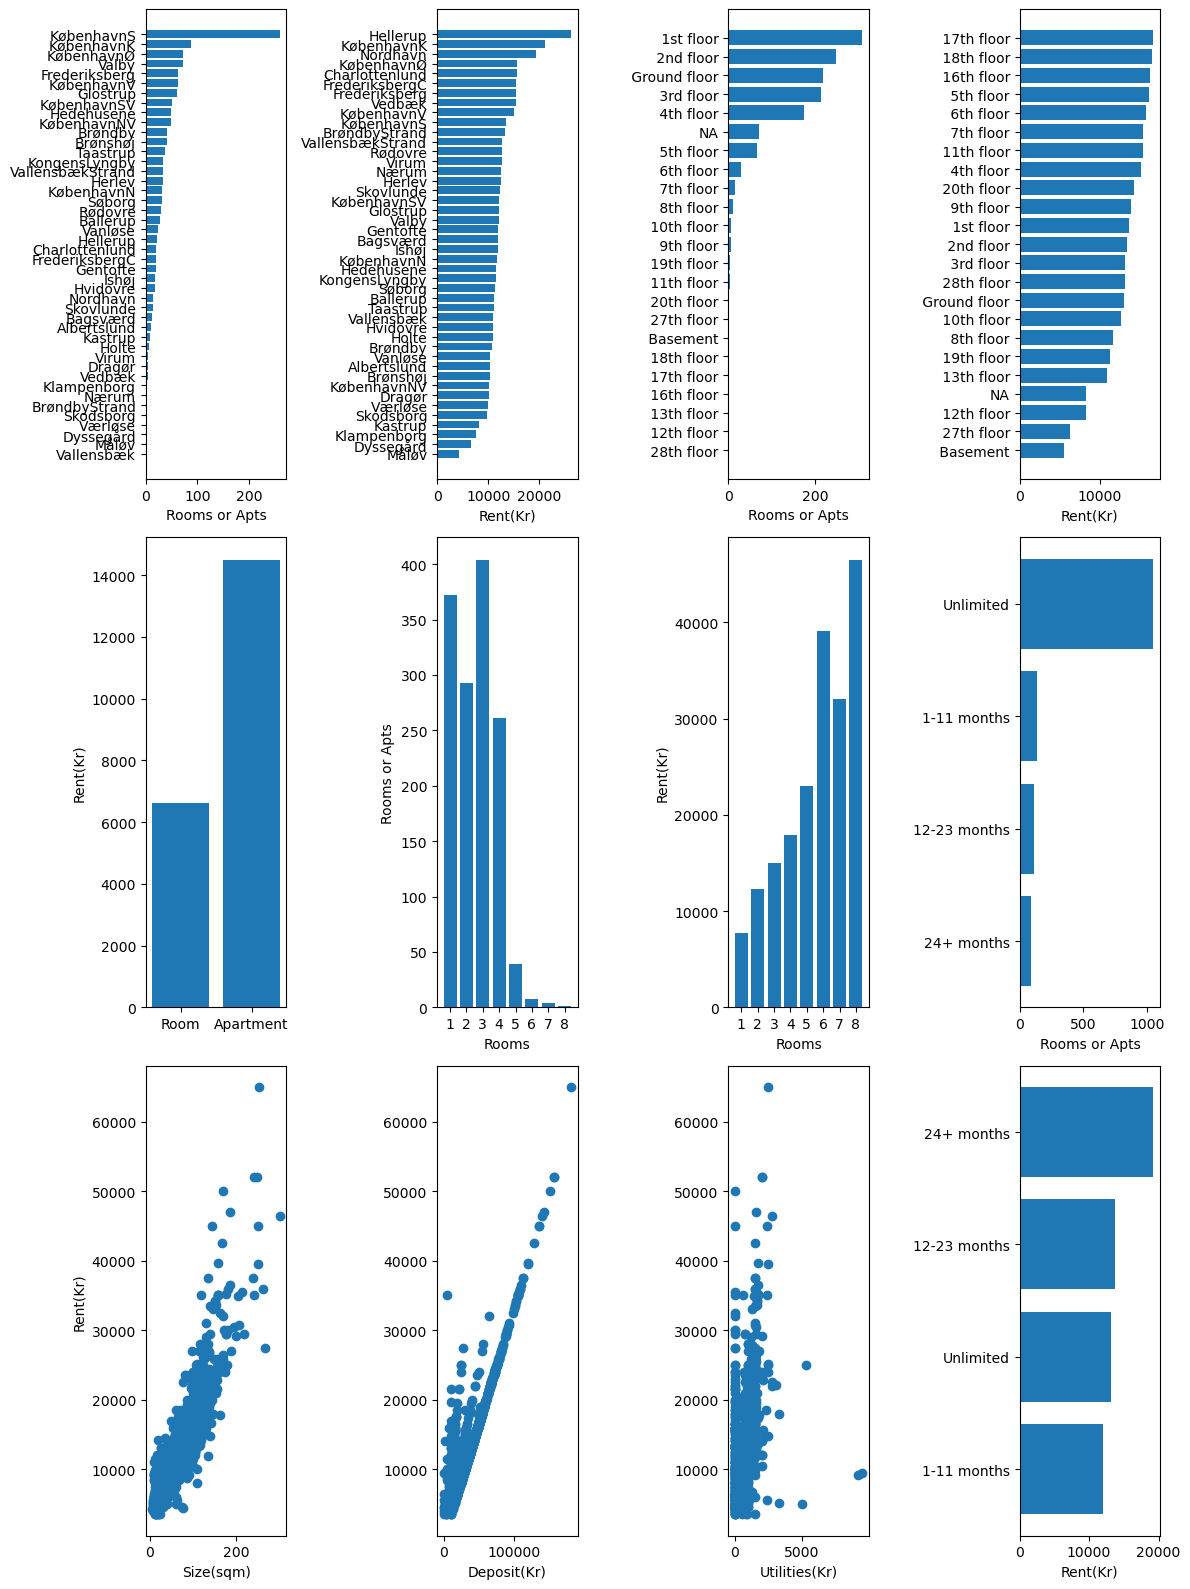

In [4]:
empty_dict = pd.read_csv("out.csv")
bolig = pd.DataFrame(empty_dict)

bolig.columns
n = len(bolig.index)

types = [x for x in bolig.loc[:,"Utilities"].unique()]
d_types = {}
for type in types:
    d_types[type] = []
    d_types[type].append(len(bolig.loc[lambda df: df["Utilities"] == type,"Utilities"]))

#lengths = []
#for i in range(n):
 #   lengths.append(len(bolig.loc[i,"Areas"]))
  #  for j in range(lengths[i]):
   #     words.append(bolig.loc[i,"Areas"][j])
        
  #  if bolig.loc[i,"Areas"][lengths[i]] != ",": 
   #     word.append(bolig.loc[i,"Areas"][i])
    
    
#for i in range(5):
 #   lengths[i] = 0

words = []
district = []
post = []
floor_full = []
for i in range(n):
    words.append(bolig.loc[i,"Areas"].split(","))
    district.append(words[i][0])
    post.append(words[i][1])
    floor_full.append(words[i][2])

floor = []
region= []
floor_full_1 = []
for i in range(len(floor_full)):
    floor_full_1.append(floor_full[i].split("-"))
    if len(floor_full_1[i]) == 1:# There are entries with missing floor number assigned with 'NA'.
        floor_full_1[i].append("NA")
    region.append(floor_full_1[i][0].replace(" ",""))
    floor.append(floor_full_1[i][1])

# Erase the city name fromt the post-code list.
for i in range(len(post)):
    post[i] = post[i].split(" ")[1]

# The four pieces of information extracted from the area description of each apt.
bolig["Street"] = district
bolig["Floor"] = floor
bolig["Neigborhood"] = region
bolig["Post"] = post

# Convert strings to floats.
bolig["Deposit"] = [float(bolig["Deposit"][i].split(" ")[0].replace(".","").split(",")[0]) for i in range(n)]
bolig["Move-in price"] = [float(bolig["Move-in price"][i].split(" ")[0].split(",")[0].replace(".","")) for i in range(n)]
bolig["Size"] = [float(bolig["Size"][i].split(" ")[0].split(",")[0]) for i in range(n)]
bolig["Monthly net rent"] = [float(bolig["Monthly net rent"][i].split(" ")[0].split(",")[0].replace(".","")) for i in range(n)]
bolig["Utilities"] = [float(str(bolig["Utilities"][i]).replace(".","").split(" ")[0].split(",")[0]) for i in range(n)]
bolig["Rooms"] = [int(bolig["Rooms"][i]) for i in range(n)]



#plt.hist(bolig["Deposit"], bins = np.linspace(min(bolig["Deposit"]),max(bolig["Deposit"]),20), density = False, cumulative = False, histtype = "bar");
np.linspace(min(bolig["Deposit"]),max(bolig["Deposit"]),20)
# "NA" or "Not Specified" values in the dataframe.
#for i in bolig.columns:
 #   print(i,len(bolig.loc[(bolig.loc[:,i] == "NA") | (bolig.loc[:,i] == "Not specified")]))

#plt.scatter(bolig["Size"], bolig["Monthly net rent"])

bolig.loc[bolig["Monthly net rent"]> 16000,"Size"]


#def plot_bar(x, y, h = False, xlabel,  ylabel):

 #   fig, ax = plt.subplots(1)

  #  if h:
   #     ax.barh(width = x, y  = y)
    #    ax.set_xlabel(xlabel)
     #   ax.set_ylabel(ylabel)
        


fig, ax = plt.subplots(3,4, figsize = (12,16))

ax[0,0].barh(width = bolig.groupby("Neigborhood")["Monthly net rent"].count().sort_values().values, 
        y = bolig.groupby("Neigborhood")["Monthly net rent"].count().sort_values().index, align = "center")
ax[0,0].set_xlabel("Rooms or Apts");

ax[0,1].barh(width = bolig.groupby("Neigborhood")["Monthly net rent"].mean().sort_values().values, 
        y = bolig.groupby("Neigborhood")["Monthly net rent"].mean().sort_values().index, align = "center")
ax[0,1].set_xlabel("Rent(Kr)");


ax[0,2].barh(width =bolig.groupby("Floor")["Monthly net rent"].count().sort_values().values, 
        y = bolig.groupby("Floor")["Monthly net rent"].count().sort_values().index, align = "center")
ax[0,2].set_xlabel("Rooms or Apts");

ax[0,3].barh(width =bolig.groupby("Floor")["Monthly net rent"].mean().sort_values().values, 
        y = bolig.groupby("Floor")["Monthly net rent"].mean().sort_values().index)
ax[0,3].set_xlabel("Rent(Kr)");


ax[1,0].bar(height =bolig.groupby("Property type")["Monthly net rent"].mean().sort_values().values, 
        x = bolig.groupby("Property type")["Monthly net rent"].mean().sort_values().index, align = "center")
ax[1,0].set_ylabel("Rent(Kr)");


ax[1,1].bar(height =bolig.groupby("Rooms")["Monthly net rent"].count().sort_values().values, 
        x = bolig.groupby("Rooms")["Monthly net rent"].count().sort_values().index, align = "center")
ax[1,1].set_xlabel("Rooms")
ax[1,1].set_ylabel("Rooms or Apts");
ax[1,1].set_xticks(ticks = range(1,max(bolig["Rooms"])+1,1));

ax[1,2].bar(height =bolig.groupby("Rooms")["Monthly net rent"].mean().sort_values().values, 
        x = bolig.groupby("Rooms")["Monthly net rent"].mean().sort_values().index, align = "center")
ax[1,2].set_xlabel("Rooms")
ax[1,2].set_ylabel("Rent(Kr)");
ax[1,2].set_xticks(ticks = range(1,max(bolig["Rooms"])+1,1));

#ax[1,2].bar(height = bolig.groupby("Furnished")["Monthly net rent"].count().sort_values().values, 
        #x = bolig.groupby("Furnished")["Monthly net rent"].count().sort_values().index, align = "center")
#ax[1,2].set_xlabel("Furnished");

ax[1,3].barh(width = bolig.groupby("Rental period")["Monthly net rent"].count().sort_values().values, 
        y = bolig.groupby("Rental period")["Monthly net rent"].count().sort_values().index, align = "center")
ax[1,3].set_xlabel("Rooms or Apts")

ax[2,0].scatter(x  = bolig["Size"], y = bolig["Monthly net rent"])
ax[2,0].set_xlabel("Size(sqm)")
ax[2,0].set_ylabel("Rent(Kr)");

ax[2,1].scatter(x  = bolig["Deposit"], y = bolig["Monthly net rent"])
ax[2,1].set_xlabel("Deposit(Kr)")
ax[2,1].set_ylabel("");
#ax[1].set_xticks(ticks = [5000,25000,50000,70000, 90000])

ax[2,2].scatter(x  = bolig["Utilities"], y = bolig["Monthly net rent"])
ax[2,2].set_xlabel("Utilities(Kr)")
ax[2,2].set_ylabel("");

ax[2,3].barh(width = bolig.groupby("Rental period")["Monthly net rent"].mean().sort_values().values, 
        y = bolig.groupby("Rental period")["Monthly net rent"].mean().sort_values().index, align = "center")
ax[2,3].set_xlabel("Rent(Kr)")

fig.tight_layout()
plt.show()


#bolig["Neigborhood"].unique()



#Note 1: If we decide that we are committed to develop a model which predicts well out of the sample, then we should keep in mind 
#that the in-sample mean squared error(MSE) is not a useful measure. Instead, cross-validation or other more generalised measures must be employed.

#Note2:  It is not very common for principal components regression to actually satisfy the modeling assumptions, 
#but it can work surprisingly well as a predictive tool anyway

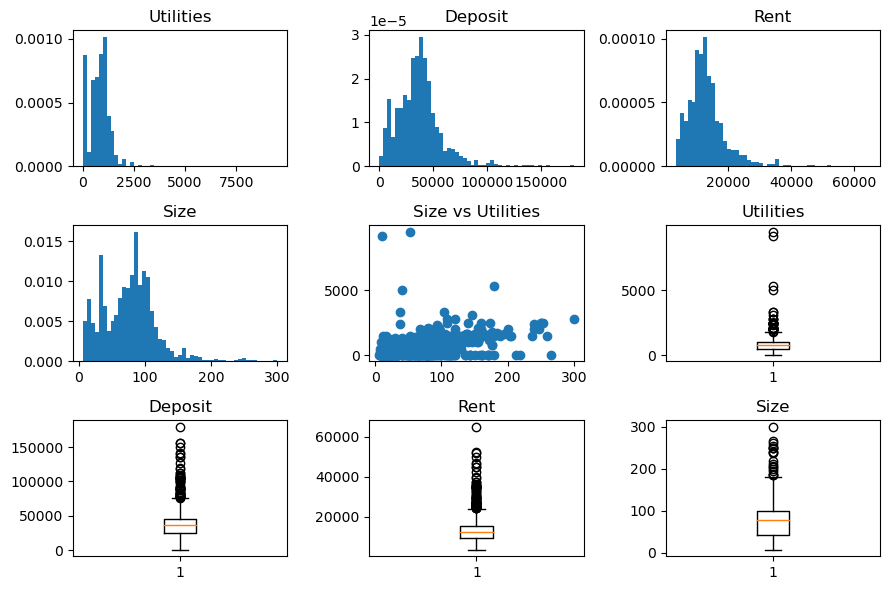

In [3]:
# Histograms and Boxplots for the numeric variables.
fig, ax = plt.subplots(3,3, figsize = (9,6))

ax[0,0].hist(bolig["Utilities"], bins = np.linspace(min(bolig["Utilities"]), max(bolig["Utilities"]),50), density = True)
ax[0,0].set_title("Utilities")
ax[0,1].hist(bolig["Deposit"], bins = np.linspace(min(bolig["Deposit"]), max(bolig["Deposit"]),50), density = True)
ax[0,1].set_title("Deposit")
ax[0,2].hist(bolig["Monthly net rent"], bins = np.linspace(min(bolig["Monthly net rent"]), max(bolig["Monthly net rent"]),50), density = True)
ax[0,2].set_title("Rent")
ax[1,0].hist(bolig["Size"], bins = np.linspace(min(bolig["Size"]), max(bolig["Size"]),50), density = True)
ax[1,0].set_title("Size")
ax[1,1].scatter(x = bolig["Size"], y = bolig["Utilities"])
ax[1,1].set_title("Size vs Utilities")
ax[1,2].boxplot(bolig["Utilities"])
ax[1,2].set_title("Utilities")
ax[2,0].boxplot(bolig["Deposit"])
ax[2,0].set_title("Deposit")
ax[2,1].boxplot(bolig["Monthly net rent"])
ax[2,1].set_title("Rent")
ax[2,2].boxplot(bolig["Size"])
ax[2,2].set_title("Size")

fig.tight_layout()
plt.show()

C:\Users\stavr\AppData\Local\Temp\ipykernel_12216\29390539.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(rotation = 90, labels =  ksq.index)


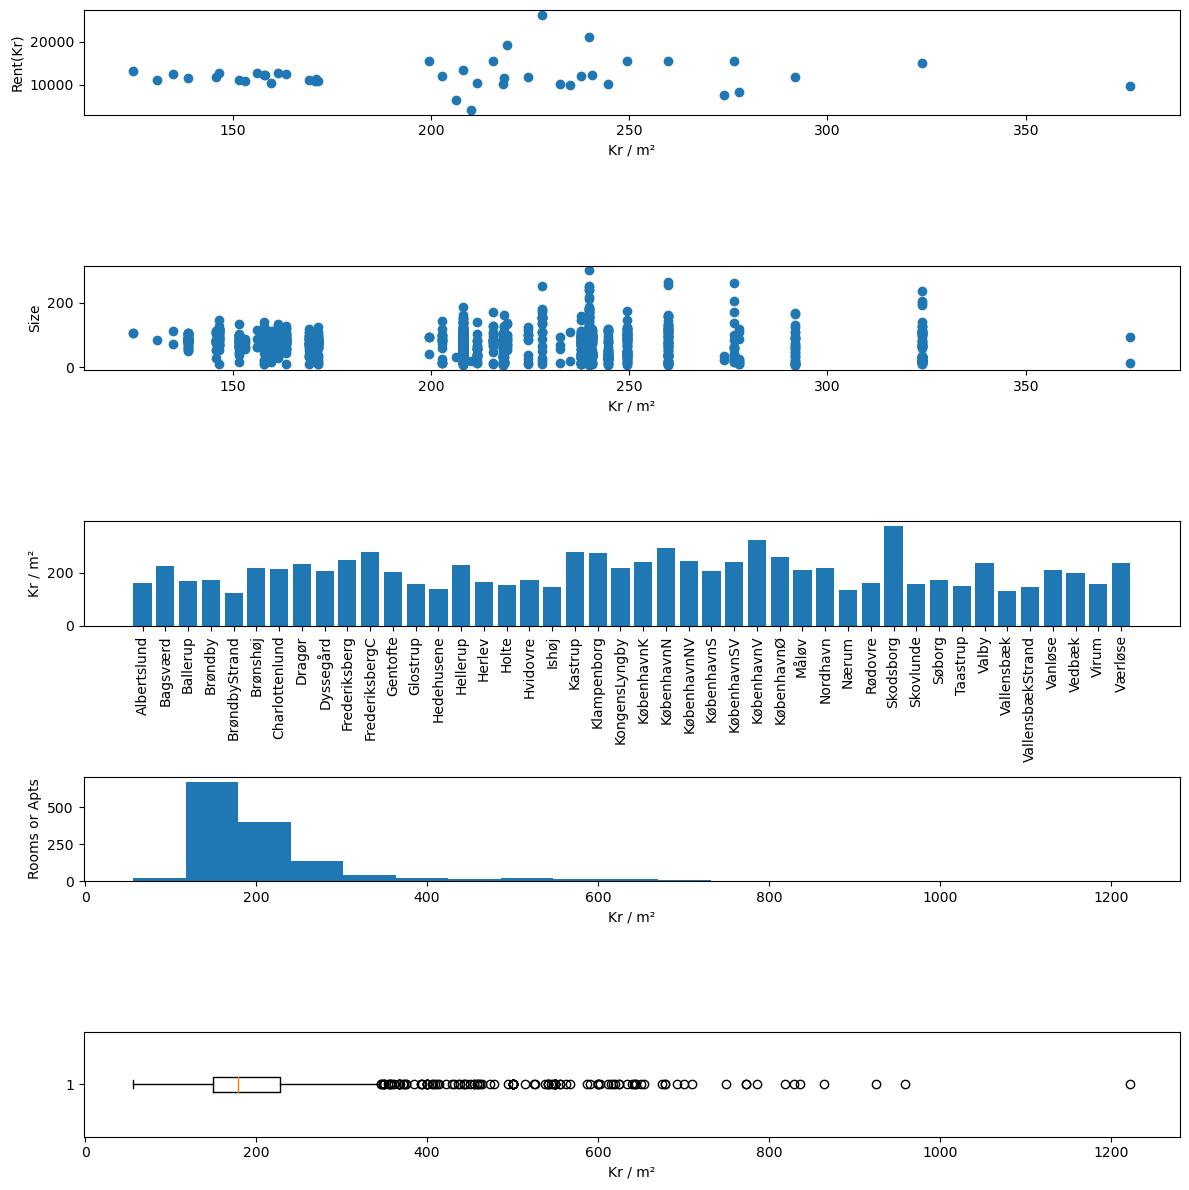

In [8]:
# Kr per Sqm(Consider adding it to the dataframe as a numeric showing the influence of the neighborhood to rent)
bolig = bolig.rename(columns={"Monthly net rent": "Monthly_net_rent"}) # Seems that the library does not support var.names with gaps.

sqmsymbol = empty_dict["Size"][1].split(" ")[1]

ksq = bolig.groupby("Neigborhood").apply(lambda df: df["Monthly_net_rent"]/df["Size"]).reset_index(name='Kr/sqm').groupby("Neigborhood")["Kr/sqm"].mean()
ksq_1 = pd.concat([bolig.groupby("Neigborhood")["Monthly_net_rent"].mean(), ksq], axis = 1)

# Add it as column to the dataframe. 
krpersq = []
for i in range(len(bolig)): 
    for nhbd in ksq.index:
        if bolig.loc[i,"Neigborhood"] == nhbd:
            krpersq.append(ksq[nhbd])
bolig["krpersq"] = krpersq

fig,ax = plt.subplots(5,1, figsize = (12,12))
ax[0].scatter(x = ksq_1["Kr/sqm"], y = ksq_1["Monthly_net_rent"])
ax[0].set_xlabel("Kr / {}".format(sqmsymbol))
ax[0].set_ylabel("Rent(Kr)")

ax[1].scatter(x = bolig["krpersq"], y = bolig["Size"])
ax[1].set_xlabel("Kr / {}".format(sqmsymbol))
ax[1].set_ylabel("Size")

ax[2].bar(height = ksq.values, x = ksq.index)
ax[2].set_xticklabels(rotation = 90, labels =  ksq.index)
ax[2].set_ylabel("Kr / {}".format(sqmsymbol))

ax[3].hist(x = bolig["Monthly_net_rent"]/bolig["Size"], bins = np.linspace(min(bolig["Monthly_net_rent"]/bolig["Size"]), 
                                                                           max(bolig["Monthly_net_rent"]/bolig["Size"]),20))
ax[3].set_xlabel("Kr / {}".format(sqmsymbol))
ax[3].set_ylabel("Rooms or Apts")

ax[4].boxplot(bolig["Monthly_net_rent"]/bolig["Size"],vert=False)
ax[4].set_xlabel("Kr / {}".format(sqmsymbol))

fig.tight_layout()
plt.show()

                            OLS Regression Results                            
Dep. Variable:       Monthly_net_rent   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     3923.
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:14:35   Log-Likelihood:                -13153.
No. Observations:                1382   AIC:                         2.631e+04
Df Residuals:                    1380   BIC:                         2.632e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3112.4093    187.698     16.582      0.0

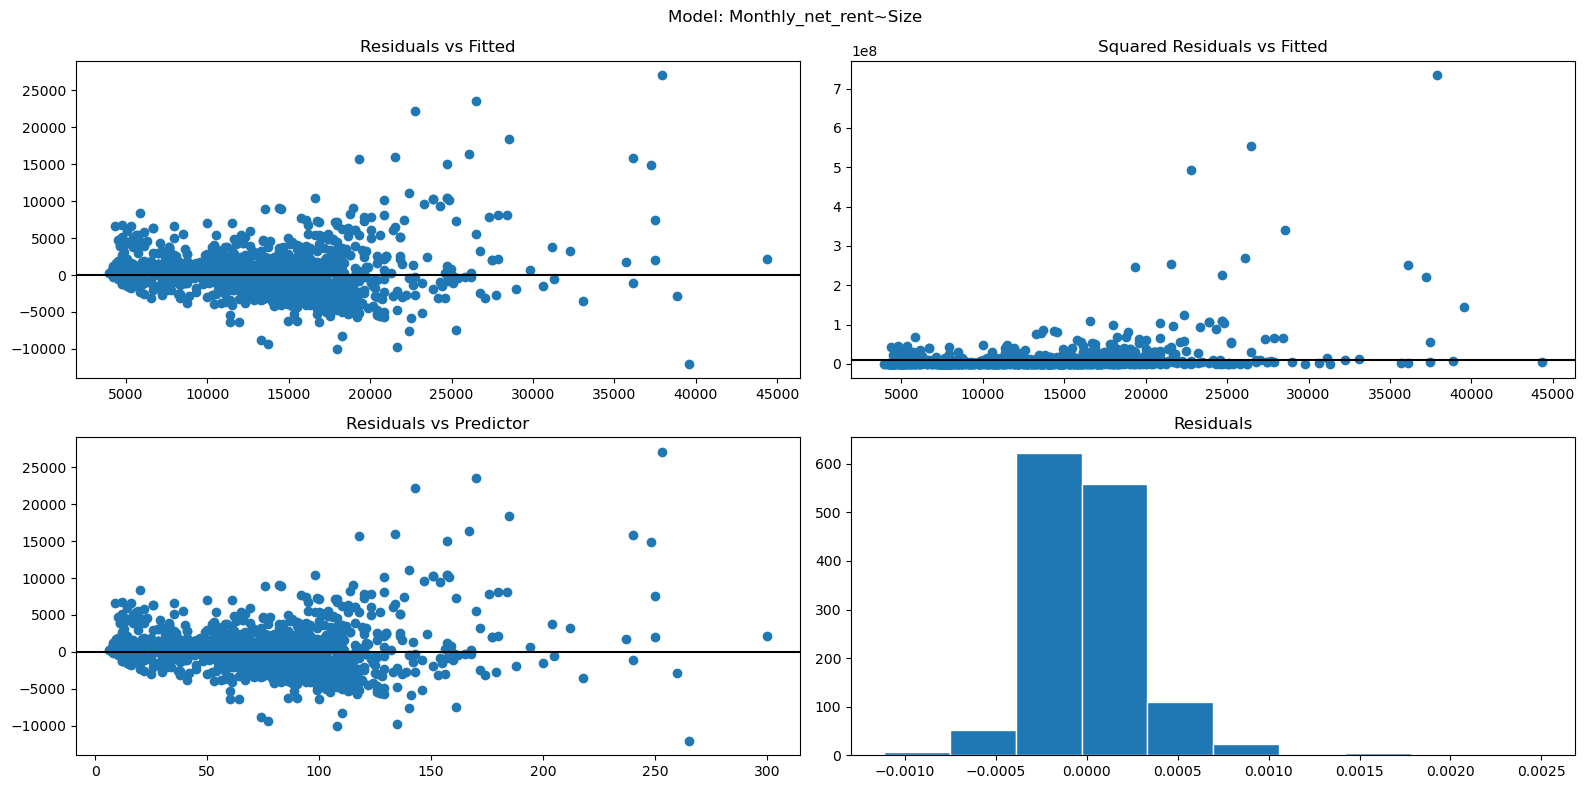

In [167]:
# Regression. We will explore different linear models for estimating the monthly rent of an apartment in Copenhagen based on the information available.
# Even though we will finally try to assess our model based on its ability to predict sufficiently well, other considerations, mainly inferencial, will also
# concern this work.


# From the previous plots, a variable with high correalation to "Monthly_net_rent" is "Size", so we start with this simple linear model. After the estimation
# of the two parameters, we investigate the diagnostics plots for checking the Gaussian assumptions of the model. 

# As the size is increasing the variance of the residuals increases too(Heteroskedasticity). This shows, among others, that the regression line on 
# one predictor(size) is less accurate when the size of the apt gets larger.
model = smf.ols(formula = "Monthly_net_rent~Size", data = bolig)
results = model.fit()

# DIAGNOSTICS: Residual and distribution plots for examining the validity of the assumptions of the normal linear regression.
def diagnostics(df, model_result, formula, ridge = False):
    fig,ax = plt.subplots(2,2,figsize = (16,8))
    if ridge == True:
        res = df["Monthly_net_rent"] - model_result.predict()
        print(ax[0,0].scatter(y = res , x = model_result.predict()),
        ax[0,0].axhline(y = 0, color = 'black'),
        ax[0,0].set_title("Residuals vs Fitted"),
        # Squared Residuals vs Fitted
        ax[0,1].scatter(y = res**2 , x = model_result.predict()),
        ax[0,1].axhline(y = np.var(res), color = 'black'),
        ax[0,1].set_title("Squared Residuals vs Fitted"),
        # Residuals vs Predictor
        ax[1,0].scatter(y = res, x = df["Size"]),
        ax[1,0].axhline(y = 0, color = 'black'),
        ax[1,0].set_title("Residuals vs Predictor"),
        # Histogram of Residuals
        ax[1,1].hist(x = ((res-np.mean(res))/np.var(res)),edgecolor ='white'),
        ax[1,1].set_title("Residuals"),
        fig.suptitle(formula),
        fig.tight_layout()
             )
        
    # Residual Plots: The two plots are really much alike\
    else:
        return(
        # Residuals vs Fitted
        ax[0,0].scatter(y = model_result.resid , x = model_result.fittedvalues),
        ax[0,0].axhline(y = 0, color = 'black'),
        ax[0,0].set_title("Residuals vs Fitted"),
        # Squared Residuals vs Fitted
        ax[0,1].scatter(y = model_result.resid**2 , x = model_result.fittedvalues),
        ax[0,1].axhline(y = np.var(model_result.resid), color = 'black'),
        ax[0,1].set_title("Squared Residuals vs Fitted"),
        # Residuals vs Predictor
        ax[1,0].scatter(y = model_result.resid, x = df["Size"]),
        ax[1,0].axhline(y = 0, color = 'black'),
        ax[1,0].set_title("Residuals vs Predictor"),
        # Histogram of Residuals
        ax[1,1].hist(x = ((model_result.resid-np.mean(model_result.resid))/np.var(model_result.resid)),edgecolor ='white'),
        ax[1,1].set_title("Residuals"),
        fig.suptitle(formula),
        fig.tight_layout(),
        plt.show()
        
    )
print(results.summary())
diagnostics(bolig, results, "Model: Monthly_net_rent~Size")
plt.show()

In [140]:
def normalise(x):
    return((x-np.mean(x))/np.var(x))

def out_of_sample(relation, df, rnd_indx, a, l, plot=False, wls = False, ridge = False):
    
    # Pick randomly the rows to keep out of the sample and then isolate this part of the dataframe
    ofs = df.iloc[rnd_indx, :]
    
    # Fit the model to all but the withdrawn sample. 
    if wls == True:
        inv_var = 1/np.var(df["Size"])
        weights=[]
        for i in range(len(df)):
            if df.loc[i,"Size"] >= 150:
                weights.append(inv_var)
            else:
                weights.append(1)
        model = smf.wls(formula = relation[0], data = df.drop(ofs.index), weights = weights)
        results = model.fit()
        # Get predictions and confidence intervals for the unseen by the model observations. 
        ofs_pred = results.get_prediction(ofs)
        preds = ofs_pred.predicted_mean
        ci = ofs_pred.summary_frame(alpha = a)# Confidence Intervals of significance alpha(a).
        preds_ci = pd.DataFrame({"CI:Lower":ci.obs_ci_lower,"Pred": preds, "CI:Upper":ci.obs_ci_upper})# A dataframe containing predictions and confidence intervals
    elif ridge == True:
        model = smf.ols(formula = relation[0], data = df.drop(ofs.index))
        results = model.fit_regularized(method = "elastic_net",alpha = l, L1_wt = 0)
        preds =  results.predict(ofs) 
    else:
        model = smf.ols(formula = relation[0], data = df.drop(ofs.index))
        results = model.fit()
        # Get predictions and confidence intervals for the unseen by the model observations. 
        ofs_pred = results.get_prediction(ofs)
        preds = ofs_pred.predicted_mean
        ci = ofs_pred.summary_frame(alpha = a)# Confidence Intervals of significance alpha(a).
        preds_ci = pd.DataFrame({"CI:Lower":ci.obs_ci_lower,"Pred": preds, "CI:Upper":ci.obs_ci_upper})# A dataframe containing predictions and confidence intervals
    # Arrange the variables
    y_vals = df.loc[ofs.index,"Monthly_net_rent"]
    res = y_vals - preds
    size,y_val = zip(*sorted(zip(ofs["Size"], y_vals)))
    size1,preds1 = zip(*sorted(zip(ofs["Size"], preds)))
    if plot == True:
        fig,ax = plt.subplots(figsize = (16,8))
        plot1 = ax.plot(size1, preds1, "b-", label = "Predicted")
        plot2 = ax.plot(size, y_val , "o", label = "Actual", color = 'orange')
        print(plot1,plot2,plt.legend(),fig.tight_layout())
    #osf_R_sq = (np.sum((y_vals-np.mean(y_vals))**2)-np.sum(res**2))/(np.sum(y_vals-np.mean(y_vals)))**2 #R-Square of the out of sample predictions
    return([#results.summary(),
           np.sum(res**2)]
          )

                            OLS Regression Results                            
Dep. Variable:       Monthly_net_rent   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     3178.
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:01:30   Log-Likelihood:                -12885.
No. Observations:                1363   AIC:                         2.577e+04
Df Residuals:                    1361   BIC:                         2.578e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3568.6875    189.045     18.877      0.0

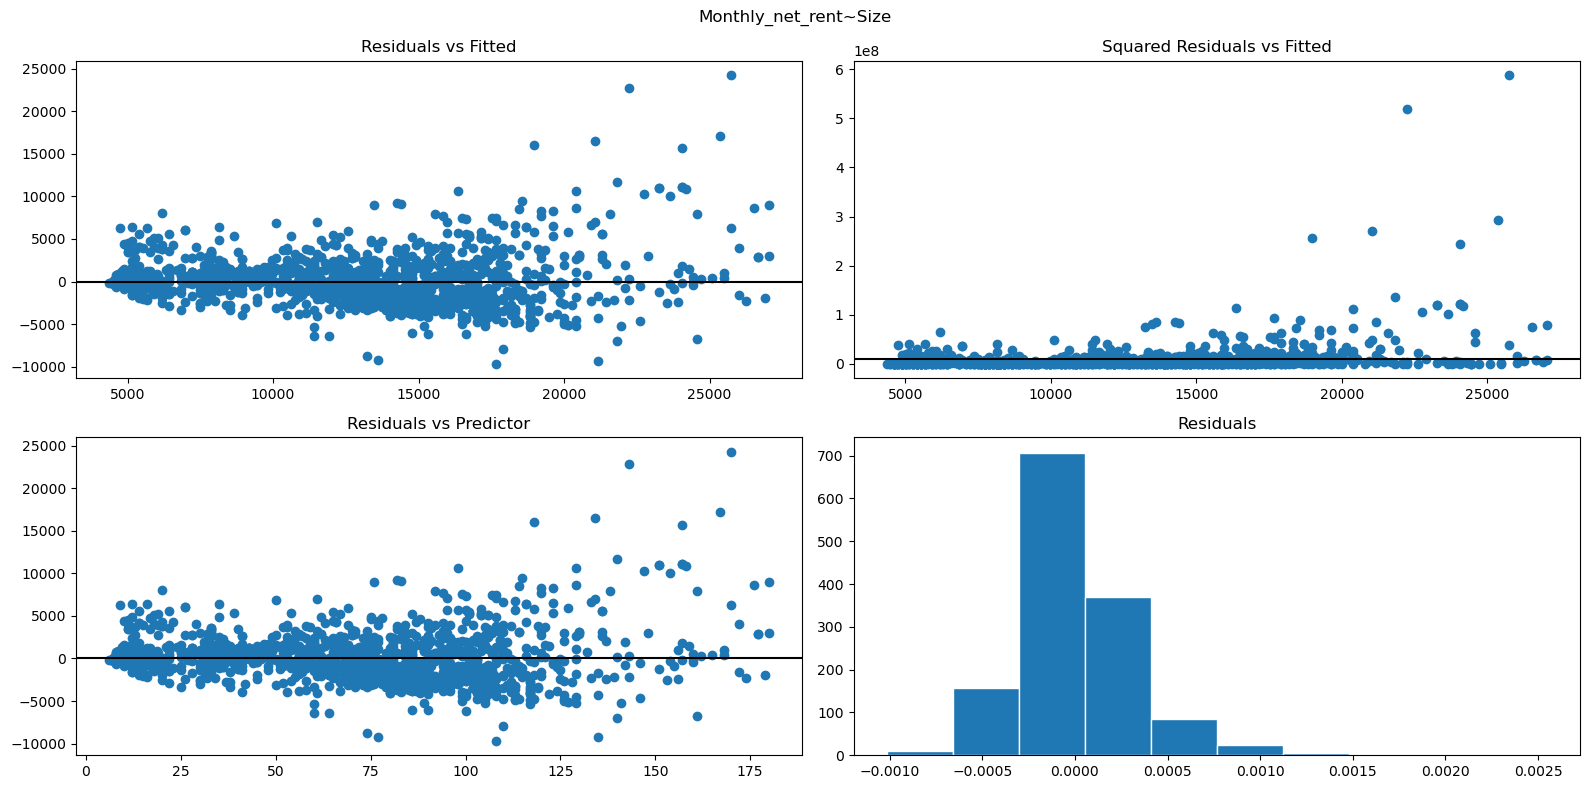

In [27]:
# We examine how the outliers of "Size" affect the parameter estimation, keeping the rest of regression assumptions the same.
# We see that neither improves the accuracy of the estimation nor provides more rigid confidence intervals for the 
# estimated parameters or less residual variance, as can be clearly seen by comparing the diagnostic plots of this and the cell above.
# Possibly, the reduction in the number of observations increased the unexplained variance of the errors without compensating with higher 
# precision estimates.
up_size_boxplot_bound = bolig["Size"].describe()[6] + (3/2)*(bolig["Size"].describe()[6]-bolig["Size"].describe()[4])

100*(bolig.shape[0] - len(bolig.loc[bolig["Size"]<= up_size_boxplot_bound]))/bolig.shape[0]# Only a vary small proportion is erased

bolig_wo_size_outliers = bolig.loc[bolig["Size"]<= up_size_boxplot_bound]

model = smf.ols(formula = "Monthly_net_rent~Size", data = bolig_wo_size_outliers)
results = model.fit()
print(results.summary())
diagnostics(bolig_wo_size_outliers,results,0,"Monthly_net_rent~Size")
plt.show()

                            OLS Regression Results                            
Dep. Variable:       Monthly_net_rent   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     2726.
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:01:36   Log-Likelihood:                -12977.
No. Observations:                1382   AIC:                         2.596e+04
Df Residuals:                    1379   BIC:                         2.598e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4431.2164    412.393    -10.745      0.0

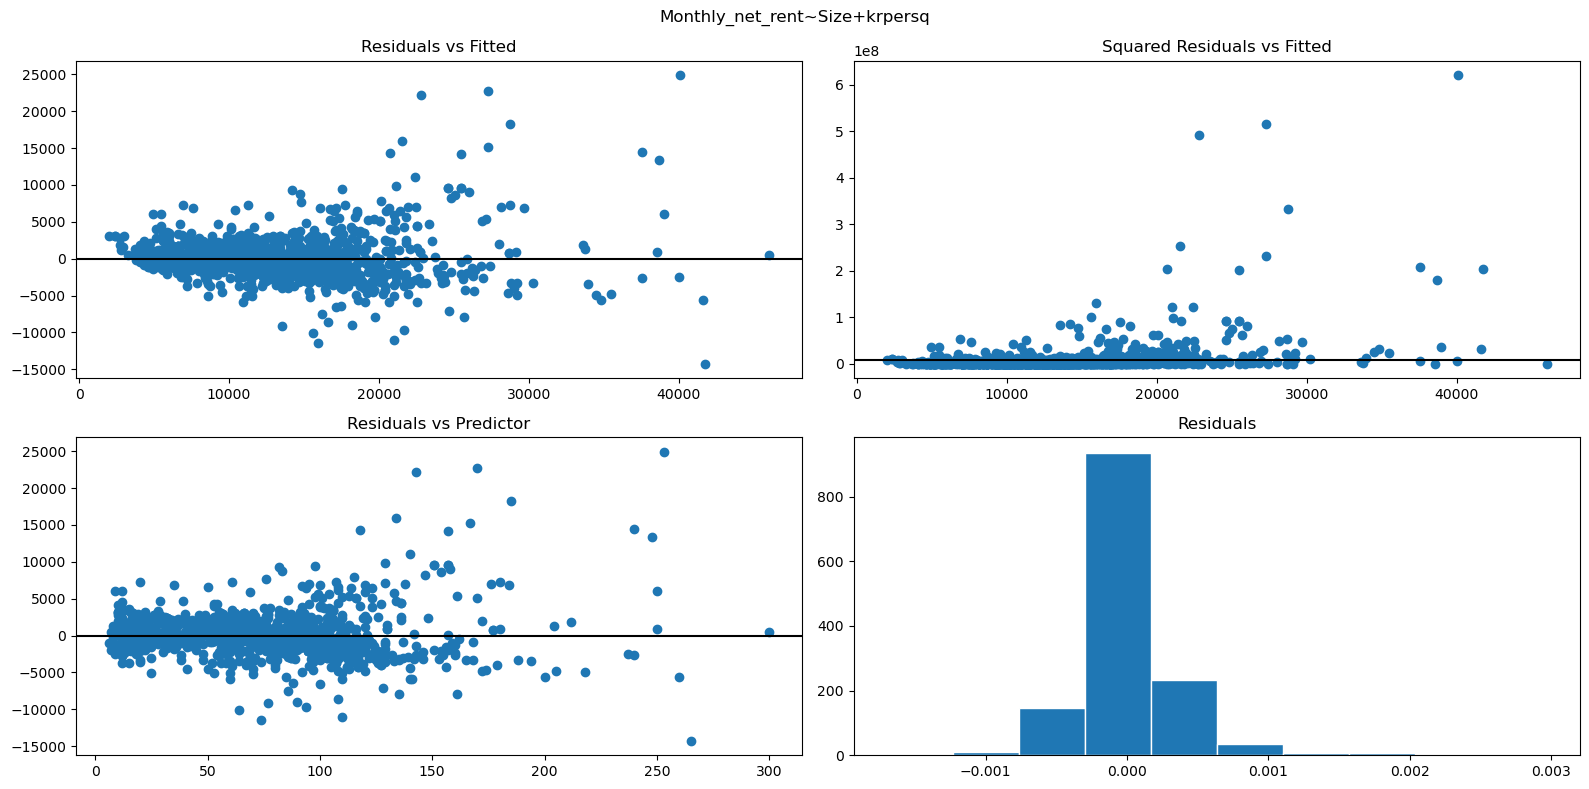

In [28]:
# Each neighborhood has its corresponding price tag per sq.meter, we will employ this variable into our model
model_1 = smf.ols(formula = 'Monthly_net_rent ~ Size + krpersq', data = bolig)
results_1 = model_1.fit()
print(results_1.summary())
diagnostics(bolig, results_1, 0, 'Monthly_net_rent~Size+krpersq')

fig.tight_layout()
plt.show()

                            OLS Regression Results                            
Dep. Variable:       Monthly_net_rent   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     157.9
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:01:51   Log-Likelihood:                -12823.
No. Observations:                1382   AIC:                         2.574e+04
Df Residuals:                    1337   BIC:                         2.597e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

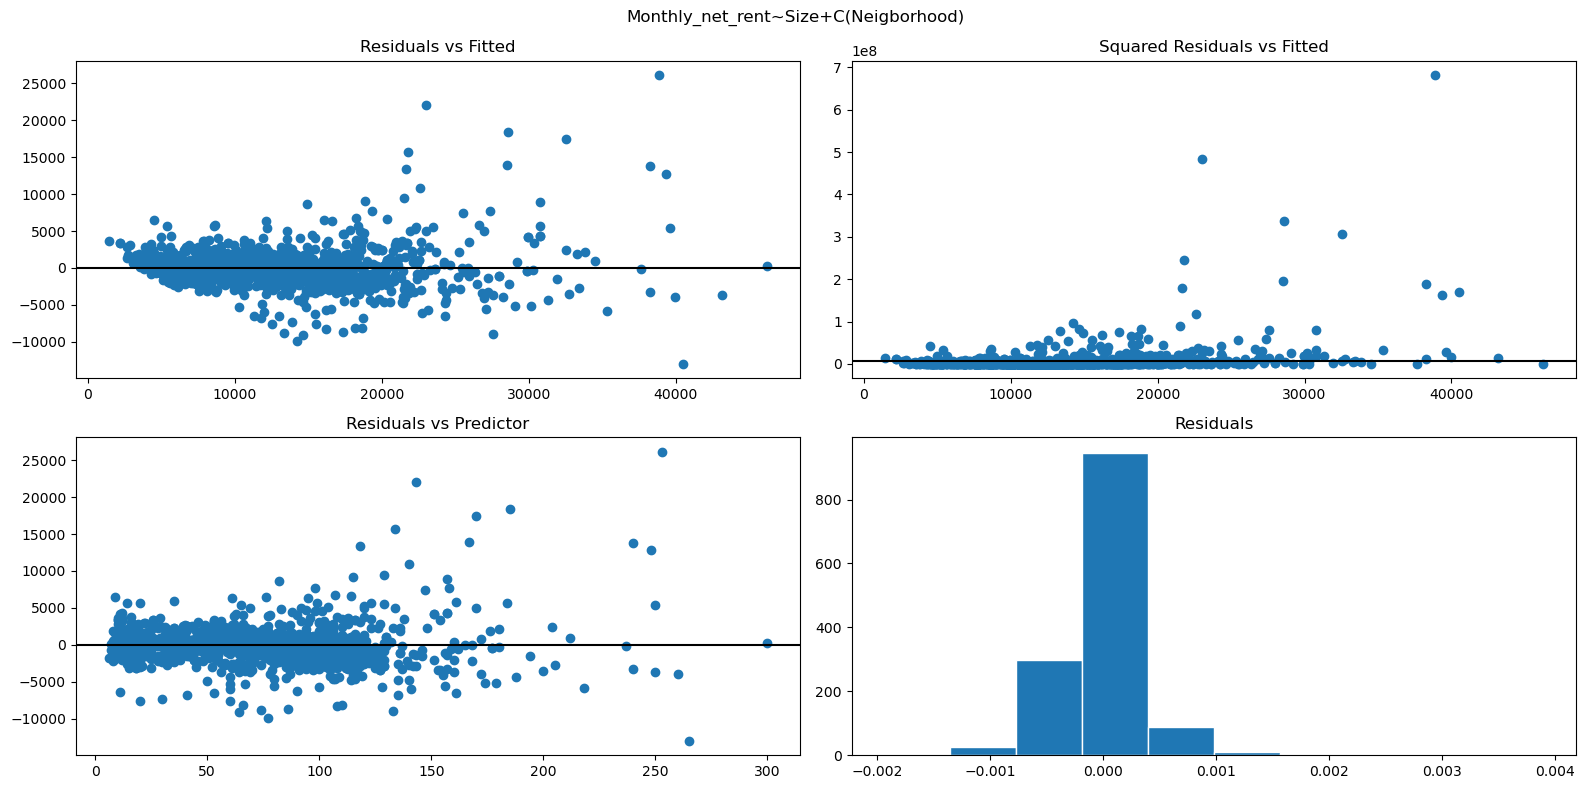

In [29]:
# Instead of using the discrete but numeric variable of krpersq, we use the original categorical variable of "Neighborhood". 
model_1 = smf.ols(formula = 'Monthly_net_rent~Size+C(Neigborhood)', data = bolig)
results_1 = model_1.fit()
print(results_1.summary())
diagnostics(bolig, results_1, 0, 'Monthly_net_rent~Size+C(Neigborhood)')
plt.show()

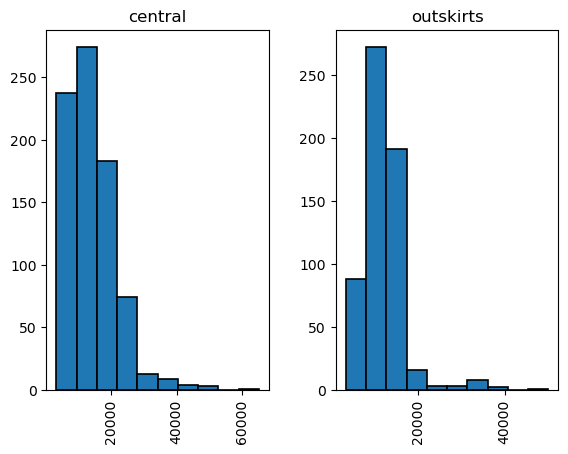

In [30]:
# Decreasing the number of classes for a categorical variable will reduce the variance of the residuals whilst introducing little, if any, bias.
# To this end, we will divide the neighborhood variable into centre and suburbs, more precisely, we divide them as follows.
outskirts = ["Virum",'VallensbækStrand', 'Skovlunde','Hedehusene', 'Hvidovre', 'Ballerup', 'Brønshøj', 'Charlottenlund', 'Brøndby', 'Værløse',
            'Taastrup', 'Glostrup', 'Hellerup', 'Holte', 'BrøndbyStrand','KongensLyngby','Rødovre', 'Albertslund', 'Søborg', 'Bagsværd',
            'Klampenborg', 'Gentofte', 'Kastrup', 'Herlev', 'Skodsborg','Dragør', 'Måløv', 'Nærum', 'Ishøj', 'Vedbæk', 'Dyssegård','Vallensbæk']
city_part = []
for i in range(bolig.shape[0]):
    if bolig["Neigborhood"][i] in outskirts:
        city_part.append("outskirts")
    else:
        city_part.append("central")

bolig["City_Part"] = city_part

# Lets see the distribution of monthly_net_rent within the two categories. It needs to be similar.
bolig.hist("Monthly_net_rent", by = "City_Part", edgecolor = 'black',linewidth = 1.2)
plt.show()

                            OLS Regression Results                            
Dep. Variable:       Monthly_net_rent   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     2547.
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:09:53   Log-Likelihood:                -13015.
No. Observations:                1382   AIC:                         2.604e+04
Df Residuals:                    1379   BIC:                         2.605e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

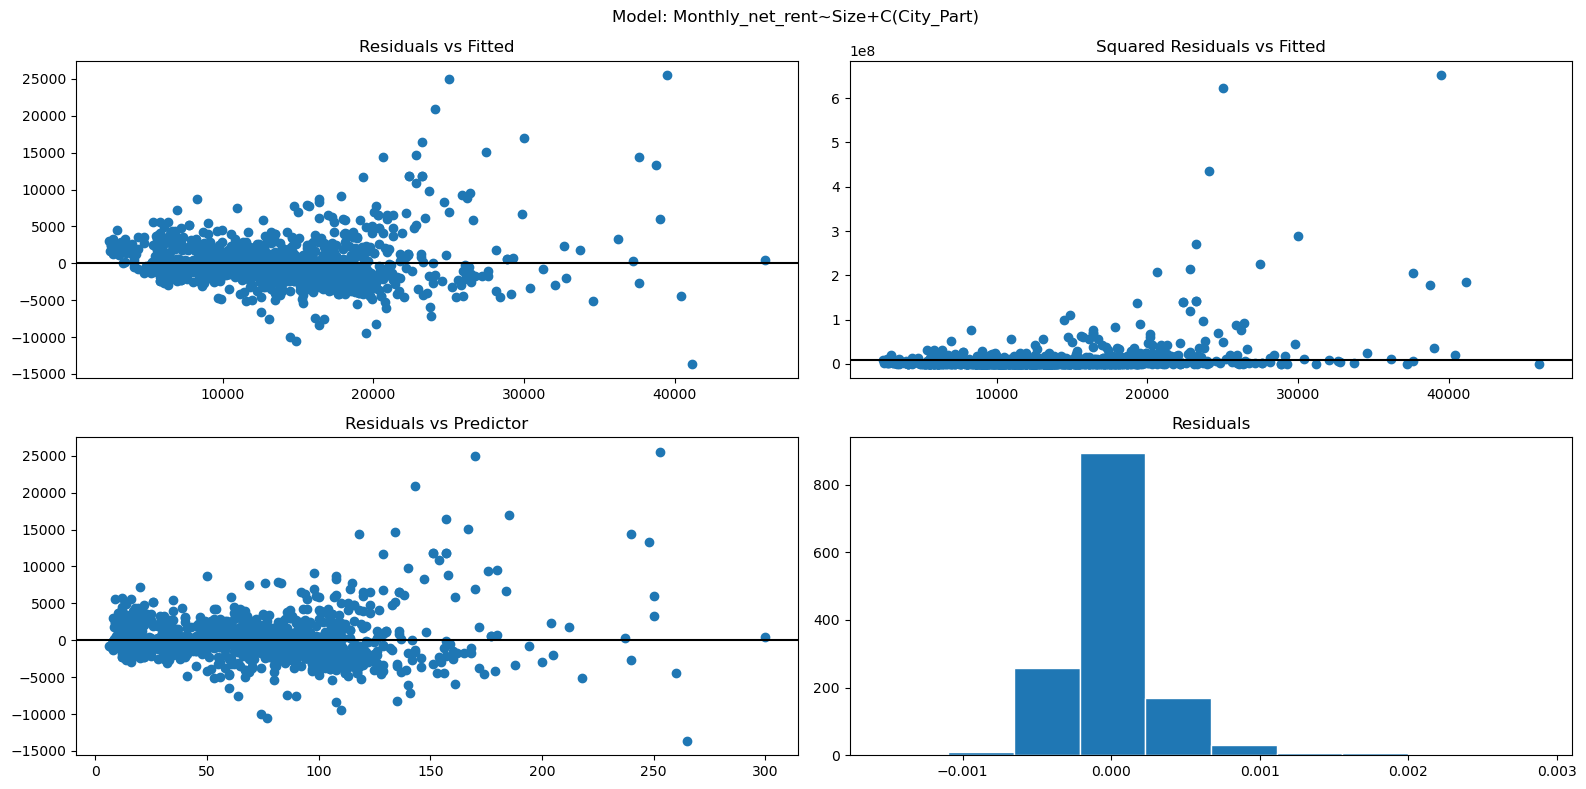

In [37]:
# Both parameteres(hence variables) are statistically significant with confidence intervals that do not contain ZERO.
# Compared to the simple model(Monthly_net_rent~Size), the model below has less residual variance, higher R^2, and smaller AIC & BIC(?).
# However, skewness and kurtosis have increased.
model = smf.ols(formula = "Monthly_net_rent~Size+C(City_Part)", data = bolig)
results = model.fit()
print(results.summary())
diagnostics(bolig, results, formula =  "Model: Monthly_net_rent~Size+C(City_Part)")
plt.show()

                            OLS Regression Results                            
Dep. Variable:       Monthly_net_rent   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1874.
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:12:40   Log-Likelihood:                -12960.
No. Observations:                1382   AIC:                         2.593e+04
Df Residuals:                    1378   BIC:                         2.595e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

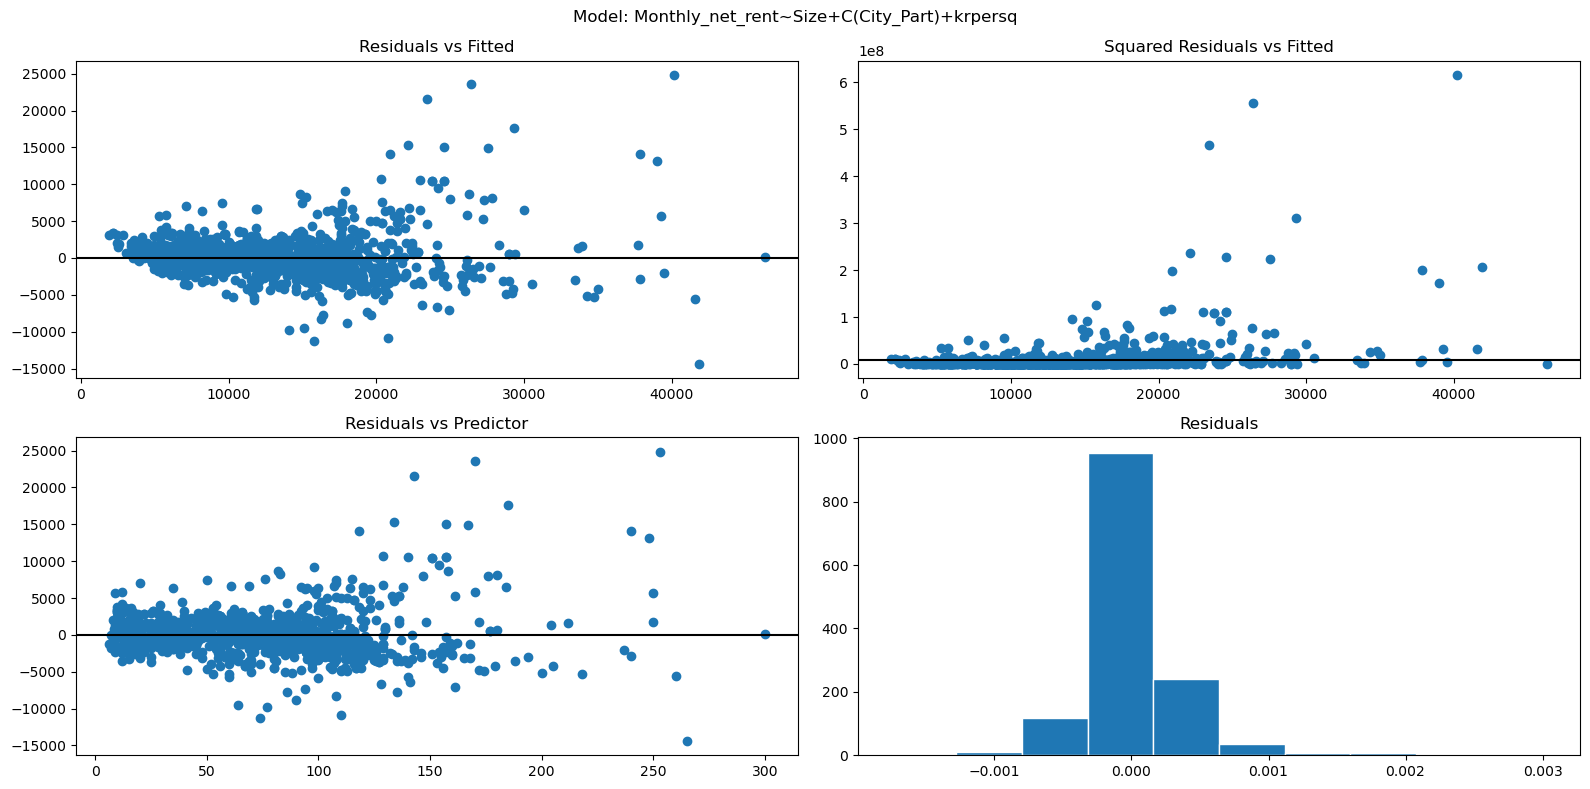

In [38]:
# Lets add the variable of Kr per Square meter. This variable being constructed from the variables of 
# Monthly_net_rent and Neighborhood is expected to demonstrate collinearity with the City_Part variable.
# Also is a variable that does nor provide clear points to infer on.
model = smf.ols(formula = "Monthly_net_rent~Size+C(City_Part)+krpersq", data = bolig)
results = model.fit()
print(results.summary())
diagnostics(bolig, results, formula =  "Model: Monthly_net_rent~Size+C(City_Part)+krpersq")
plt.show()

In [112]:
# 
res_sq = []
for i in range(len(bolig)):
    out = out_of_sample(relation = ["Monthly_net_rent~Size+krpersq"], 
              df = bolig.loc[:,["Size","Monthly_net_rent", "krpersq"]], rnd_indx = [i], a = 0.05, plot = False)
    res_sq.append(out[1])
    
np.mean(res_sq)

8463669.054768682

In [111]:
res_sq = []
for i in range(len(bolig)):
    out = out_of_sample(relation = ["Monthly_net_rent~Size+C(City_Part)+krpersq"], 
              df = bolig.loc[:,["Size","Monthly_net_rent", "City_Part", "krpersq"]], rnd_indx = [i], a = 0.05, plot = False)
    res_sq.append(out[1])
    
np.mean(res_sq)

8270584.715368448

                            OLS Regression Results                            
Dep. Variable:       Monthly_net_rent   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     556.4
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:28:26   Log-Likelihood:                -13085.
No. Observations:                1382   AIC:                         2.619e+04
Df Residuals:                    1373   BIC:                         2.623e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3070.4534    205.299     14.956

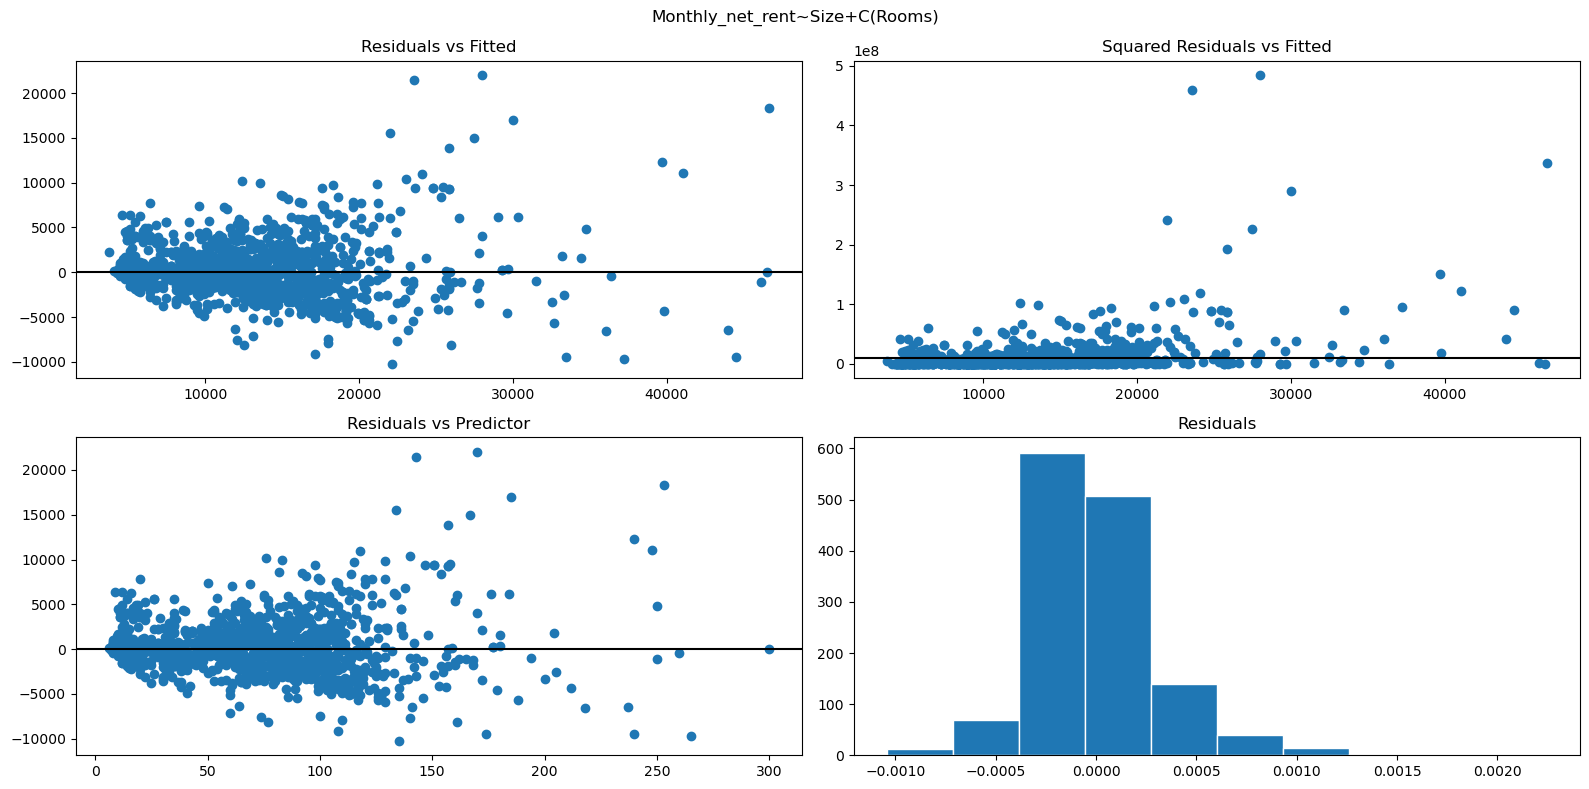

In [105]:
# We now introduce the categorical variable of "Rooms". It is transformed into dummy variables
# and the estimated parameters are the contrasts of each class against the reference class while all other variables are identical. 
model_1 = smf.ols(formula = 'Monthly_net_rent~Size+C(Rooms)', data = bolig)
results_1 = model_1.fit()
print(results_1.summary())
diagnostics(bolig, results_1, 'Monthly_net_rent~Size+C(Rooms)')
plt.show()

In [108]:
# We will perform a similar class reduction to the Rooms variable. Looking at the analytics above, there is an(almost) monotone
# relation between the Rent and the number of rooms. As the majority of rooms or apts have at most 2 rooms and the trend of rent
# figure is climbing for apts with more than 4 rooms, we decide to perform the separation as follows:
roomin = []
for i in range(bolig.shape[0]):
    if bolig["Rooms"][i] <= 2 :
        roomin.append(0)
    else:
        roomin.append(1)

bolig["Roomin"] = roomin

bolig.groupby(["Roomin"])["Roomin"].count()

Roomin
0    665
1    717
Name: Roomin, dtype: int64

                            OLS Regression Results                            
Dep. Variable:       Monthly_net_rent   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     1428.
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:30:29   Log-Likelihood:                -12951.
No. Observations:                1382   AIC:                         2.591e+04
Df Residuals:                    1377   BIC:                         2.594e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

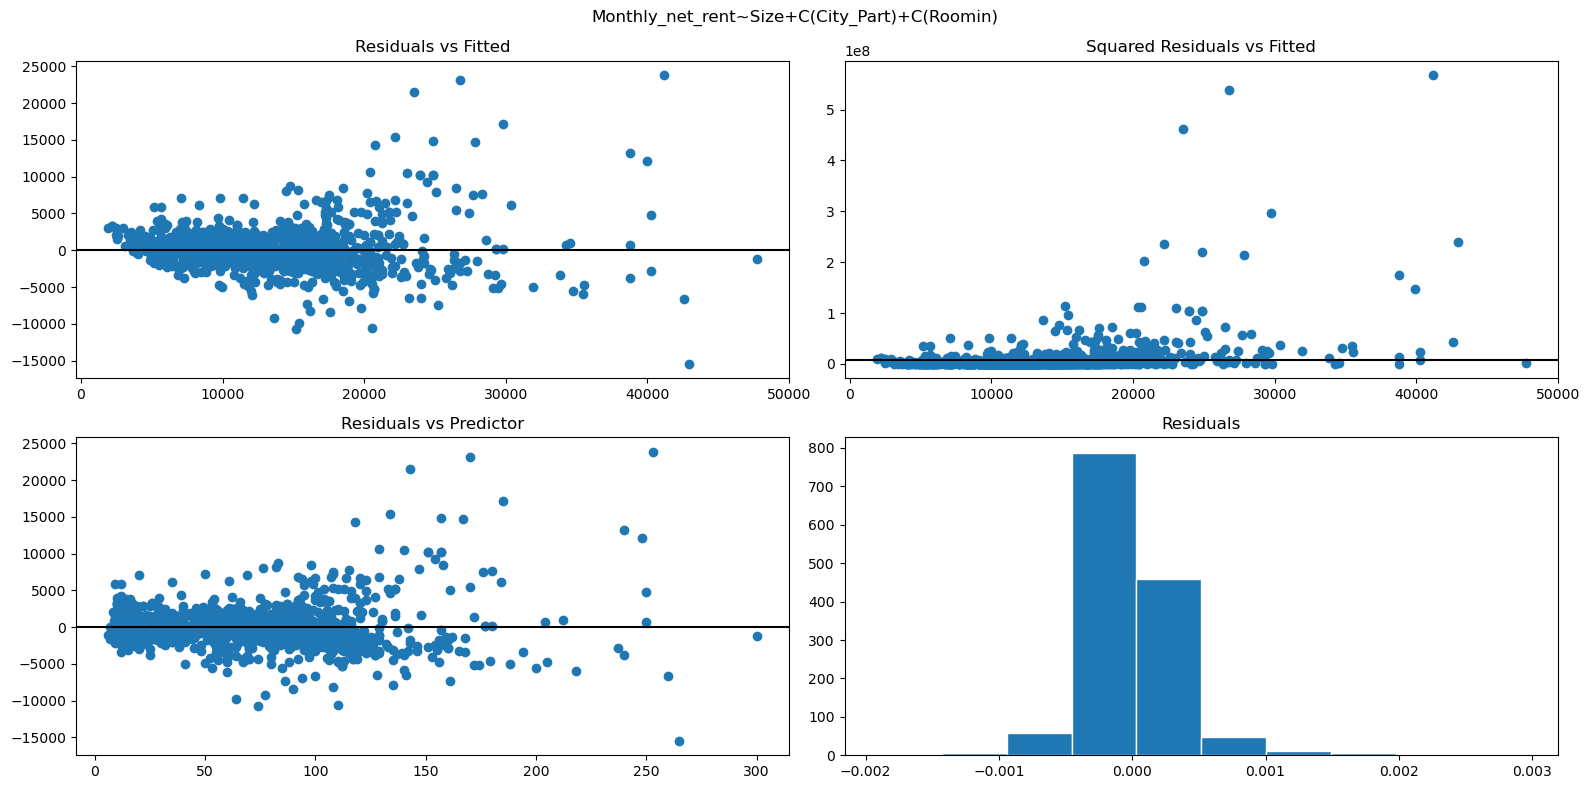

In [109]:
# It seems that adding the Roomin variable ameliorates the model performance.
model_4 = smf.ols(formula = "Monthly_net_rent~Size+krpersq+C(City_Part)+C(Roomin)", data = bolig)
results_4 = model_4.fit()
print(results_4.summary())
diagnostics(bolig, results_4, "Monthly_net_rent~Size+C(City_Part)+C(Roomin)")
plt.show()

In [110]:
# Smaller out-of-sample squared error than without the Roomin varible, thus we proceed with it. 
res_sq = []
for i in range(len(bolig)):
    out = out_of_sample(relation = ["Monthly_net_rent~Size+krpersq+C(City_Part)+C(Roomin)"], 
              df = bolig.loc[:,["Size","Monthly_net_rent", "City_Part", "krpersq", "Roomin"]], rnd_indx = [i], a = 0.05, plot = False)
    res_sq.append(out[1])
    
res_sq_norm = normalise(res_sq)
np.mean(res_sq)

8185984.20327125

In [113]:
# Trying to find more predictors that could potentialy improve our regression modelling, we start by looking at the mean rent value
# for many of the variables available in the dataset. We observet that, there difference in Monthly_net_rent is on average more significant
# among the variables of: Elevator, Balcony, Dishwasher(many NAs though), Washing machine(many NAs too) & Dryer(again, many NAs).
cols = ['Property type', 'Furnished', 'Shareable', 'Elevator','Balcony', 'Parking', 'Dishwasher', 'Washing machine', 'Dryer']

for col in cols:
    print(pd.concat([bolig.groupby(col)["Monthly_net_rent"].mean(),
         bolig.groupby(col)[col].count()], axis = 1))

               Monthly_net_rent  Property type
Property type                                 
Apartment          14503.644759           1202
Room                6633.061111            180
           Monthly_net_rent  Furnished
Furnished                             
No             13679.454955       1110
Yes            12658.591912        272
               Monthly_net_rent  Shareable
Shareable                                 
No                 13435.054968        946
Not specified      13700.000000          2
Yes                13572.281106        434
               Monthly_net_rent  Elevator
Elevator                                 
No                 12879.146341       410
Not specified      12915.666667        72
Yes                13796.615556       900
               Monthly_net_rent  Balcony
Balcony                                 
No                 11941.473815      401
Not specified      15127.233766       77
Yes                14019.915929      904
               Monthly_net

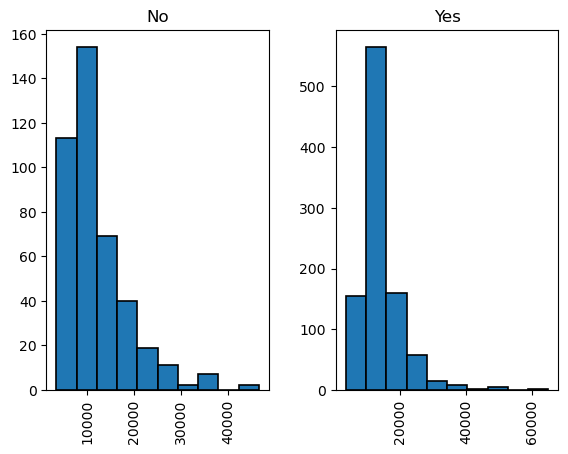

,Monthly_net_rent,Balcony
Balcony,,
No,11954.422062,417
Yes,14137.137824,965


In [114]:
# Lets start the variable of "Balcony". We firstly need to deal with the "Not specified" values.
# An appraoch could be to distribute the "Not specified" among "yes" and "no" for each floor value, for every apt.
# This is sensible, as "Floor" is the most relevant variable to the "Balcony" variable, and because in this way we can 
# provide a more sophisticated manner of distributing the missing values. So, what we do is that we calculate the probability
# of a room not having a balcony for each floor, and then we perform reversed Bernouli(1: "No", 0:"Yes") to classify the not
# specified balcony values.

floor_balcony = bolig.groupby(["Floor","Balcony"])["Balcony"].count()

theta = []
floor = []
for i in range(len(floor_balcony)-1):
    if (floor_balcony.index[i+1][1] == "Not specified")&(floor_balcony.index[i][1] == "No"):
        total = floor_balcony[i]+floor_balcony[i+1]+floor_balcony[i+2]
        floor.append(floor_balcony.index[i][0])
        theta.append(floor_balcony[i]/total)
    elif (floor_balcony.index[i][1] == "Not specified")&(floor_balcony.index[i+1][1] == "Yes")&(floor_balcony.index[i-1][1] != "No"):
        floor.append(floor_balcony.index[i][0])
        theta.append(0)

np.random.seed(123)
fl_bal = {}
for i in range(len(floor)):
    fl_bal[floor[i]] = theta[i]

bolig_copy = bolig.copy()# As we profoundly change the dataframe, we choose to make a copy of the dataframe and apply the changes there
for floor_no in fl_bal.keys():
    for i in range(len(bolig_copy["Floor"])):
        if (bolig_copy.loc[i,"Floor"] == floor_no) & (bolig_copy.loc[i,"Balcony"] == "Not specified"):
            th = fl_bal[floor_no]
            dist = np.random.binomial(1,th,1)
            if dist == 1:
                bolig_copy.loc[i,"Balcony"] = "No"
            else:
                bolig_copy.loc[i,"Balcony"] = "Yes"

bolig_copy.hist("Monthly_net_rent", by = "Balcony", edgecolor = "black", linewidth = 1.2)
plt.show()
bolig_copy.groupby(["Balcony"]).agg({"Monthly_net_rent" : "mean", "Balcony":"count"})

                            OLS Regression Results                            
Dep. Variable:       Monthly_net_rent   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     1148.
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:40:51   Log-Likelihood:                -12947.
No. Observations:                1382   AIC:                         2.591e+04
Df Residuals:                    1376   BIC:                         2.594e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

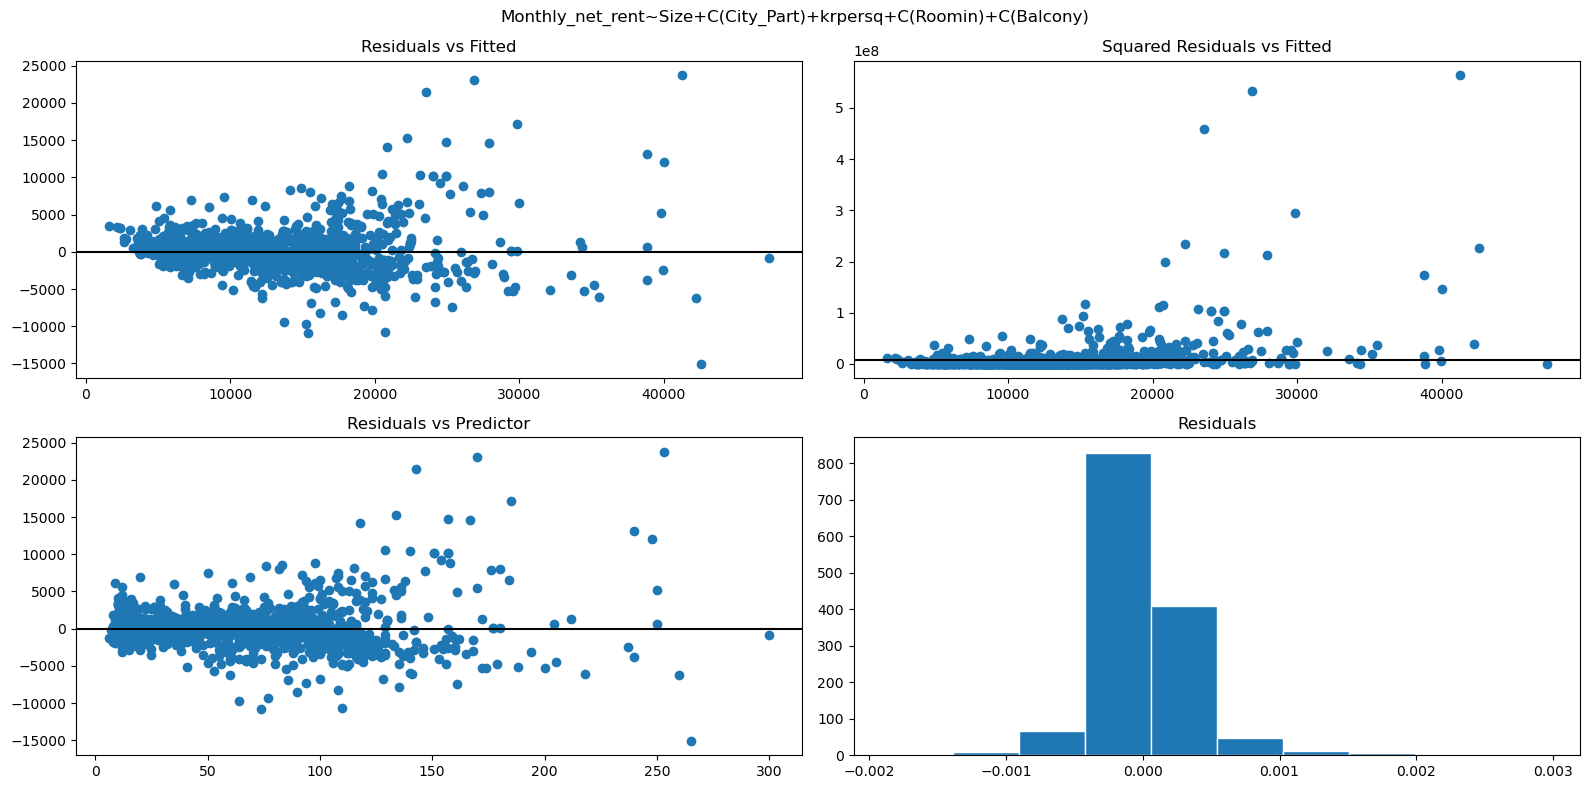

In [117]:
# Not much difference to the model without the "Balcony" variable, however all parameters are statistically significant with 
# similarly variant confidence intervals.
model = smf.ols(formula = "Monthly_net_rent~Size+C(City_Part)+krpersq+C(Roomin)+C(Balcony)", data = bolig_copy)
results = model.fit()
print(results.summary())
diagnostics(bolig_copy, results, "Monthly_net_rent~Size+C(City_Part)+krpersq+C(Roomin)+C(Balcony)")
plt.show()

In [118]:
# The inclusion of "Balcony" in the model has led to smaller out-of-sample squared errors.
res_sq = []
for i in range(len(bolig)):
    out = out_of_sample(relation = ["Monthly_net_rent~Size+C(City_Part)+krpersq+C(Roomin)+C(Balcony)"], 
              df = bolig_copy.loc[:,["Size","Monthly_net_rent", "krpersq","City_Part", "Roomin", "Balcony"]], rnd_indx = [i] ,a = 0.05, plot = False,wls = False)
    res_sq.append(out[1])
np.mean(res_sq)

8154008.364772729

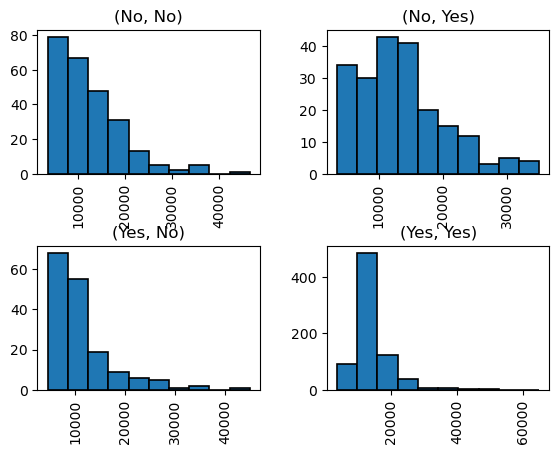

Monthly_net_rent  Elevator
Elevator Balcony                            
No       No           12228.231076       251
         Yes          13632.019324       207
Yes      No           11540.409639       166
         Yes          14275.079156       758

In [115]:
# Similarly to balcony, we introduce the "Elevator" variable. Again, the allocation of Null values will be based on the variable of floor.
bolig.groupby(["Elevator","Floor"])["Floor"].count()

# It is reasonable to set the elevator variable to "No" for the ground floor apts. However, before that, lets see if anything realted to 
# the elevtor is mentioned to the ad description text. We found one rental that mentions that the apt includes an elevator. 
tf=[]
for indx in bolig_copy.loc[(bolig_copy["Elevator"] == "Not specified")].index:
    tf.append("elevator" in bolig.loc[indx,"Sub_title"])
idx = bolig_copy[bolig_copy["Elevator"] == "Not specified"].loc[tf,"Sub_title"].index# The ONE rental.
bolig_copy.loc[idx,"Elevator"] == "Yes"

# All those from the 3d floor and above not specifying whether there is an elevator are placed at "No" class.
for i in range(len(bolig_copy)):
    if (bolig_copy.loc[i,"Elevator"] == "Not specified")&(bolig_copy.loc[i,"Floor"] == " Ground floor"):
        bolig_copy.loc[i,"Elevator"] = "No"
    elif((bolig_copy.loc[i,"Elevator"] == "Not specified")&(bolig_copy.loc[i,"Floor"] in [" 3rd floor", " 4th floor", " 5th floor", " 8th floor"])):
        bolig_copy.loc[i,"Elevator"] = "No"


floor_elev = bolig_copy.groupby(["Floor","Elevator"])["Elevator"].count()


theta_elev = []
floor_elev_list = []
for i in range(len(floor_elev)-1):
    if (floor_elev.index[i+1][1] == "Not specified")&(floor_elev.index[i][1] == "No"):
        total = floor_elev[i]+floor_elev[i+1]+floor_elev[i+2]
        floor_elev_list.append(floor_elev.index[i][0])
        theta_elev.append(floor_elev[i]/total)
    elif (floor_elev.index[i][1] == "Not specified")&(floor_elev.index[i+1][1] == "Yes")&(floor_elev.index[i-1][1] != "No"):
        floor_elev.append(floor_balcony.index[i][0])
        theta_elev.append(0)


fl_elev = {}
for i in range(len(floor_elev_list)):
    fl_elev[floor_elev_list[i]] = theta_elev[i]

for floor_no in fl_elev.keys():
    for i in range(len(bolig_copy["Floor"])):
        if (bolig_copy.loc[i,"Floor"] == floor_no) & (bolig_copy.loc[i,"Elevator"] == "Not specified"):
            th = fl_elev[floor_no]
            dist = np.random.binomial(1,th,1)
            if dist == 1:
                bolig_copy.loc[i,"Elevator"] = "No"
            else:
                bolig_copy.loc[i,"Elevator"] = "Yes"

bolig_copy.hist("Monthly_net_rent", by = ["Elevator", "Balcony"], edgecolor = "black", linewidth = 1.2)
plt.show()
bolig_copy.groupby(["Elevator", "Balcony"]).agg({"Monthly_net_rent" : "mean", "Elevator":"count"})

                            OLS Regression Results                            
Dep. Variable:       Monthly_net_rent   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     957.8
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:25:40   Log-Likelihood:                -12946.
No. Observations:                1382   AIC:                         2.591e+04
Df Residuals:                    1375   BIC:                         2.594e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

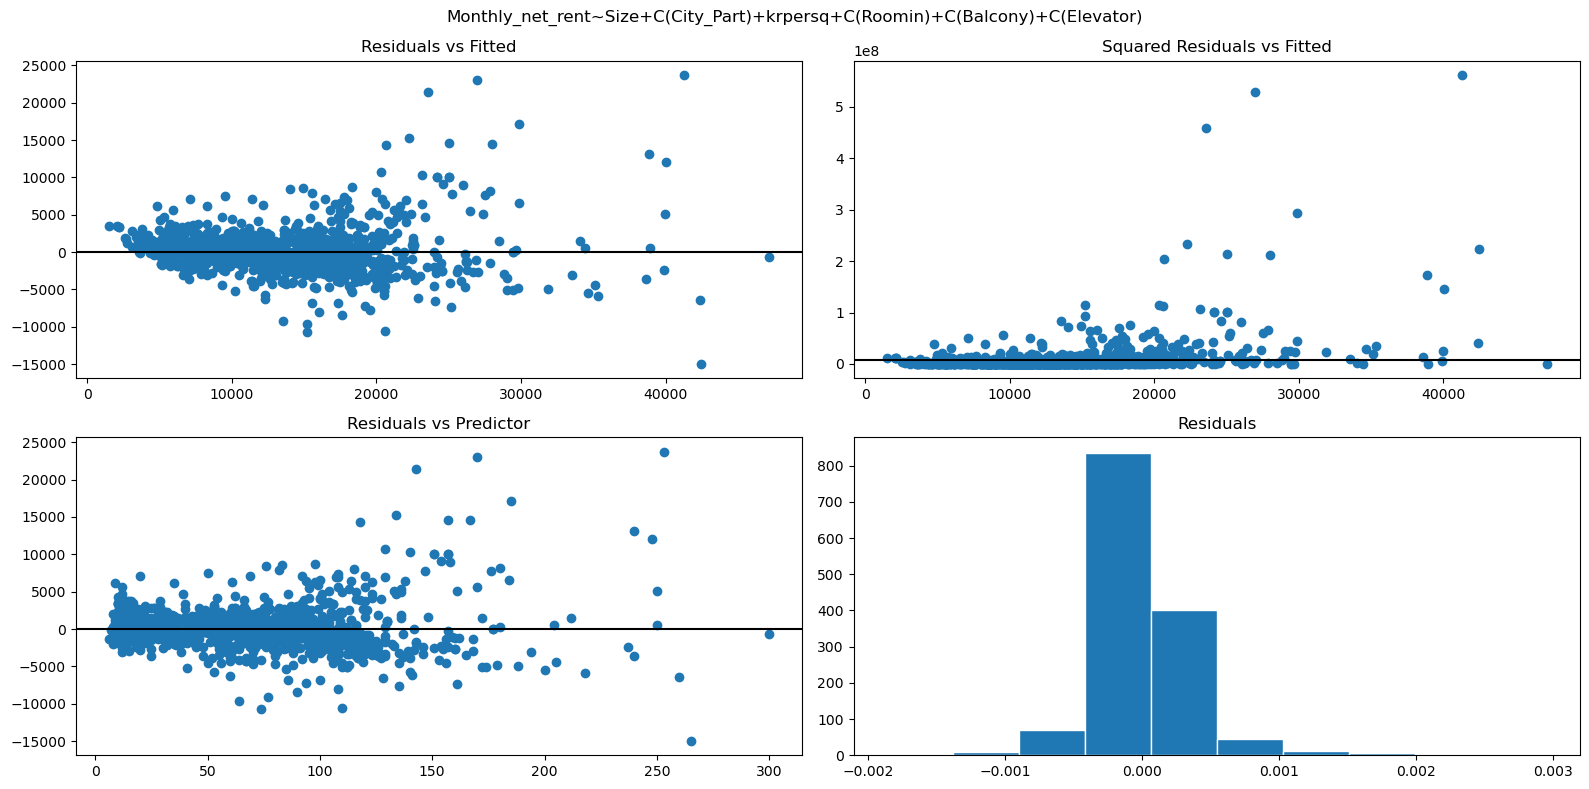

In [171]:
# It seems that the variable of elevator does not provide significant information to the model. It is very likely to 
# have insignificant parameter, the R-sqaured is the same, while the signs of multicollinearity are increased(check condition no.)
# Moreover, the diagnostics witness no substantial change after the  introduction of the "Elevator" variable. Last, 
# the out-of-sample squared errors are lightly increased(see below). Hence, we decide to continue without the variable 
# of elevator.
model = smf.ols(formula = "Monthly_net_rent~Size+C(City_Part)+krpersq+C(Roomin)+C(Balcony)+C(Elevator)", data = bolig_copy)
results = model.fit()
print(results.summary())
diagnostics(bolig_copy, results, "Monthly_net_rent~Size+C(City_Part)+krpersq+C(Roomin)+C(Balcony)+C(Elevator)")
plt.show()

In [170]:
res_sq = []
for i in range(len(bolig)):
    out = out_of_sample(relation = ["Monthly_net_rent~Size+C(City_Part)+krpersq+C(Roomin)+C(Balcony)+C(Elevator)"], 
              df = bolig_copy.loc[:,["Size","Monthly_net_rent", "krpersq","City_Part", "Roomin", "Balcony", "Elevator"]], rnd_indx = [i] ,a = 0.05, 
                        plot = False,wls = False, l = 0)
    res_sq.append(out[0])
np.mean(res_sq)

8156289.269002333

                            WLS Regression Results                            
Dep. Variable:       Monthly_net_rent   R-squared:                       0.772
Model:                            WLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     930.8
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:58:06   Log-Likelihood:                -12866.
No. Observations:                1382   AIC:                         2.574e+04
Df Residuals:                    1376   BIC:                         2.578e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

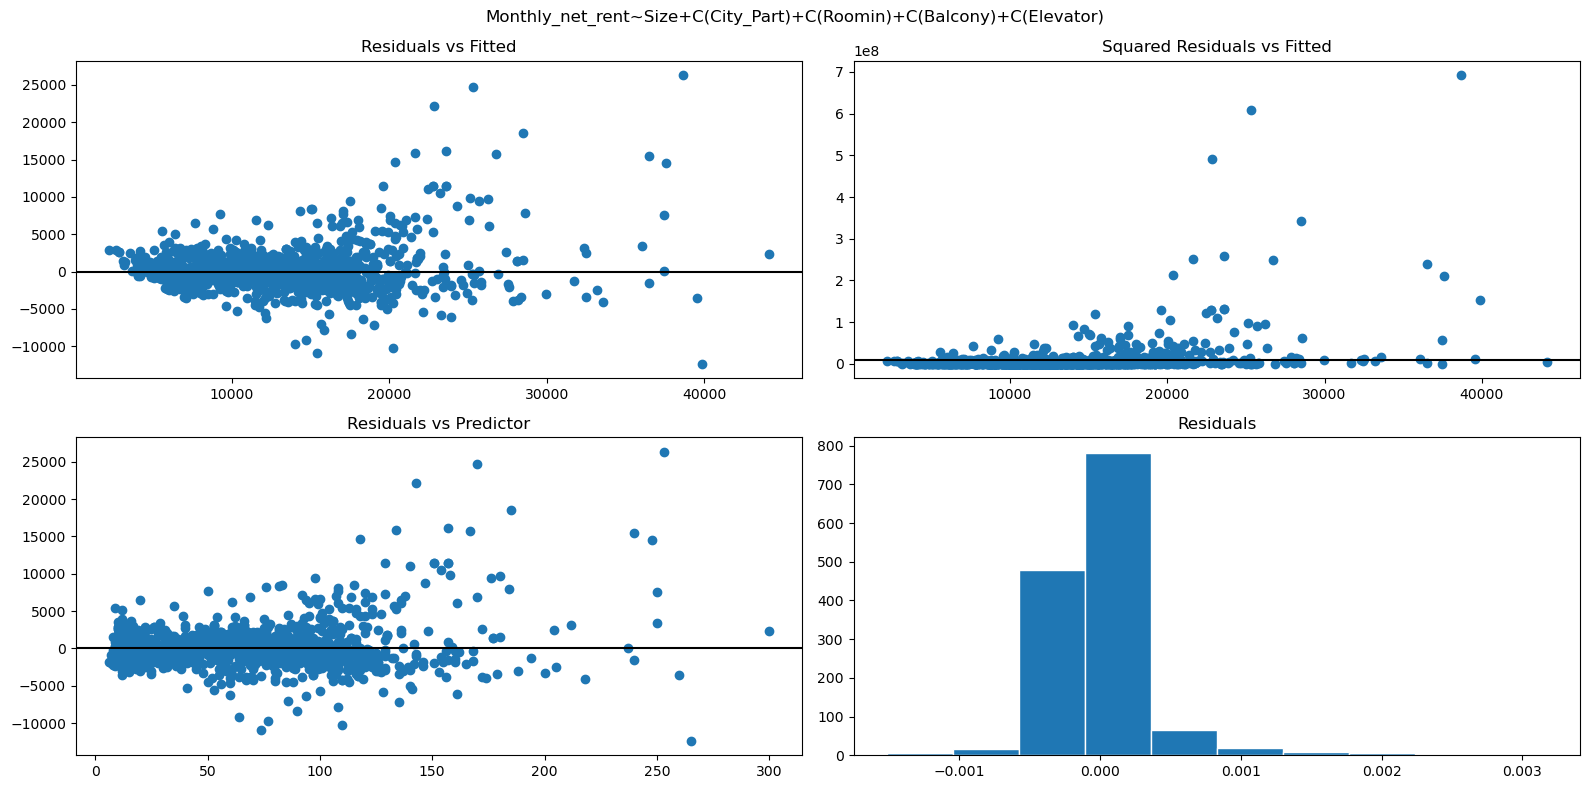

In [148]:
# Weighted Least Squares : Throughtout the analysis so far, whenever we checked the normal assumptions of the linear regression model the variance of the 
# errors is always increasing with size. In other words, the predictions of the model are getting worse as the values of size increase. An idea for dealing
# with this issue would be to assign higher weights to observations where low error variance occurs. 
inv_var = 1/np.var(bolig_copy["Size"])
weights=[]
for i in range(len(bolig_copy)):
    if bolig_copy.loc[i,"Size"] >= 150:
        weights.append(inv_var)
    else:
        weights.append(1)
model = smf.wls(formula = "Monthly_net_rent~Size+krpersq+C(City_Part)+C(Roomin)+C(Balcony)", data = bolig_copy, weights = weights)
results = model.fit()
print(results.summary())
diagnostics(bolig_copy, results, "Monthly_net_rent~Size+C(City_Part)+C(Roomin)+C(Balcony)")
plt.show()

In [121]:
# Out-of-sample predictions and squared errors for the Weighted Least Squares model above. The result is worse than that of the model
# without weights applying to each data observation.
res_sq = []
for i in range(len(bolig)):
    out = out_of_sample(relation = ["Monthly_net_rent~Size+krpersq+C(City_Part)+C(Roomin)+C(Balcony)"], 
              df = bolig_copy.loc[:,["Size","Monthly_net_rent", "City_Part", "krpersq", "Roomin", "Balcony"]], rnd_indx = [i], a = 0.05, 
                        plot = False, wls = True)
    res_sq.append(out[1])
np.mean(res_sq)

8266501.23516883

In [146]:
# A last resort for improving our out-of-sample score or the better realising the normal assumptions of the model. 
# Ridge(or Lasso) regression: Usually improves the prediction accuracy of the model even if the issue of multi-collinearity remains.
# We first need to find an appropriate Ridge weight. To this end, we perform the same out-of-sample predictions, this time for four different
# values of Ridge weights. We see that as the weight is decreasing the model's squared errors is decreasing too. However, we observe that the 
# difference between the two last weights is very small, consequently we decide to not try out smaller weight values.  
dict = dict.fromkeys([0.5, 0.1,0.01,0.001])
for l in [0.5, 0.1,0.01,0.001]:
    res_sq = []
    for i in range(len(bolig_copy)):
        out = out_of_sample(relation = ["Monthly_net_rent~Size+krpersq+C(City_Part)+C(Roomin)+C(Balcony)"], 
                            df = bolig_copy.loc[:,["Size","Monthly_net_rent", "City_Part", "krpersq", "Roomin", "Balcony"]], 
                            rnd_indx = [i], a = 0.05, l = l, plot = False, wls = False, ridge = True)
        res_sq.append(out[0])
    dict[l] = np.mean(res_sq)
dict

{0.5: 8583168.715098923,
 0.1: 8250412.41752359,
 0.01: 8154660.642102165,
 0.001: 8152625.390676593}

<matplotlib.collections.PathCollection object at 0x000001E855D62FA0> Line2D(_child1) Text(0.5, 1.0, 'Residuals vs Fitted') <matplotlib.collections.PathCollection object at 0x000001E855D9A4F0> Line2D(_child1) Text(0.5, 1.0, 'Squared Residuals vs Fitted') <matplotlib.collections.PathCollection object at 0x000001E855D9ACD0> Line2D(_child1) Text(0.5, 1.0, 'Residuals vs Predictor') (array([  1.,   8.,  67., 839., 400.,  46.,  12.,   5.,   1.,   3.]), array([-1.87132990e-03, -1.38798607e-03, -9.04642241e-04, -4.21298412e-04,
        6.20454171e-05,  5.45389246e-04,  1.02873308e-03,  1.51207690e-03,
        1.99542073e-03,  2.47876456e-03,  2.96210839e-03]), <BarContainer object of 10 artists>) Text(0.5, 1.0, 'Residuals') Text(0.5, 0.98, 'Monthly_net_rent~Size+krpersq+C(City_Part)+C(Roomin)+C(Balcony)') None


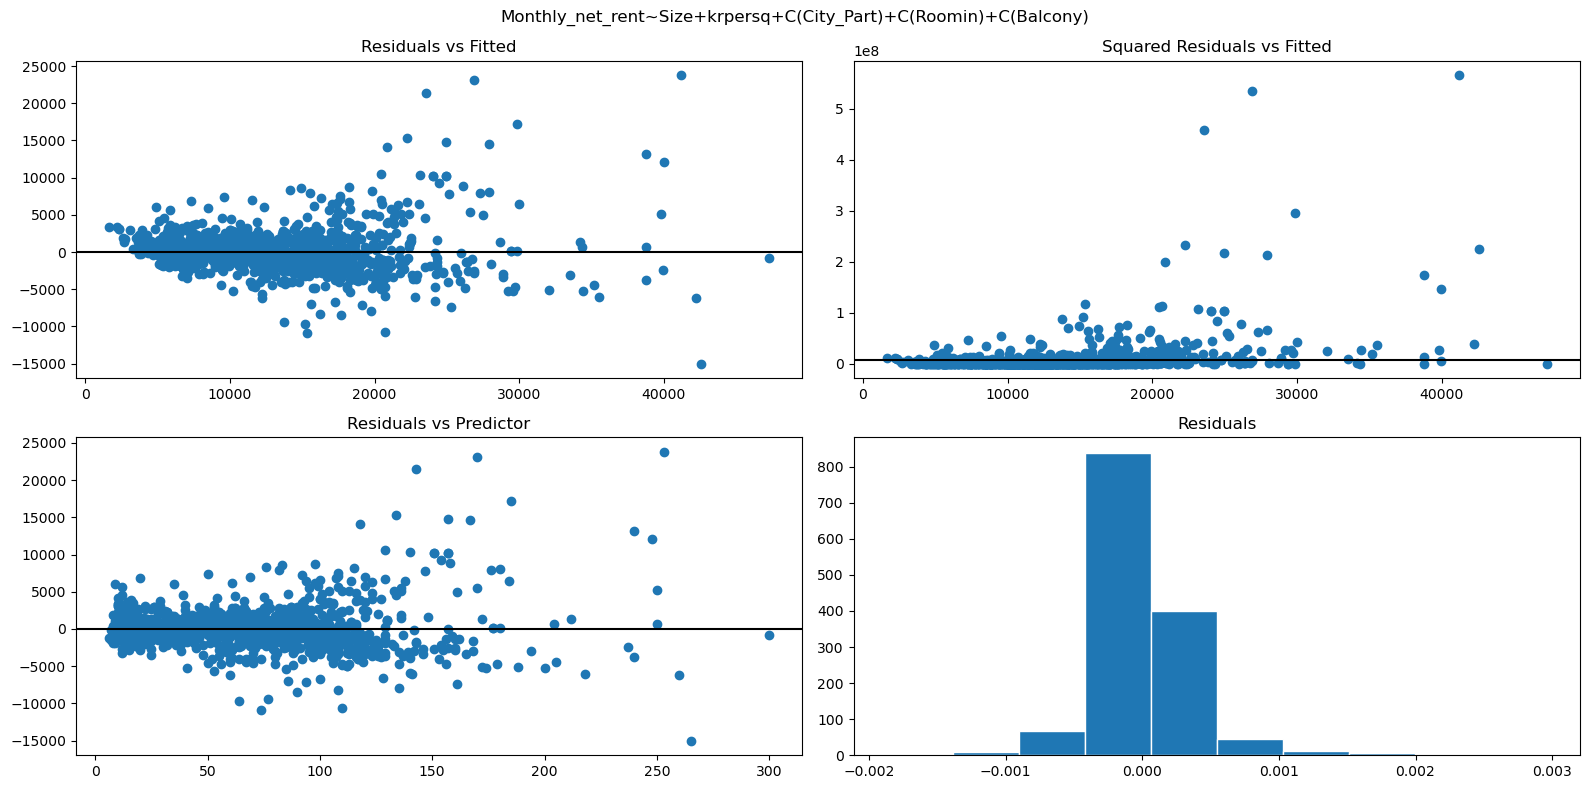

In [168]:
# Lets investigate the Ridge model above a bit more. 
# There is no visible improvement in the diagnostics of the ridge model compared to the ones(weightless) developed above.
# However, the squared errors are slightly smaller than those of the model without ridge coefficient. Hence, the ridge model
# might provide slightly more accurate predictions.
model = smf.ols(formula = "Monthly_net_rent~Size+krpersq+C(City_Part)+C(Roomin)+C(Balcony)", data = bolig_copy)
results = model.fit_regularized(method = "elastic_net",alpha = 0.001, L1_wt = 0)

diagnostics(bolig_copy, results, "Monthly_net_rent~Size+krpersq+C(City_Part)+C(Roomin)+C(Balcony)", ridge = True)
plt.show()

[<matplotlib.lines.Line2D object at 0x000001E8548F3D30>] [<matplotlib.lines.Line2D object at 0x000001E8548F3FD0>] Legend None


[832196752.5591463]

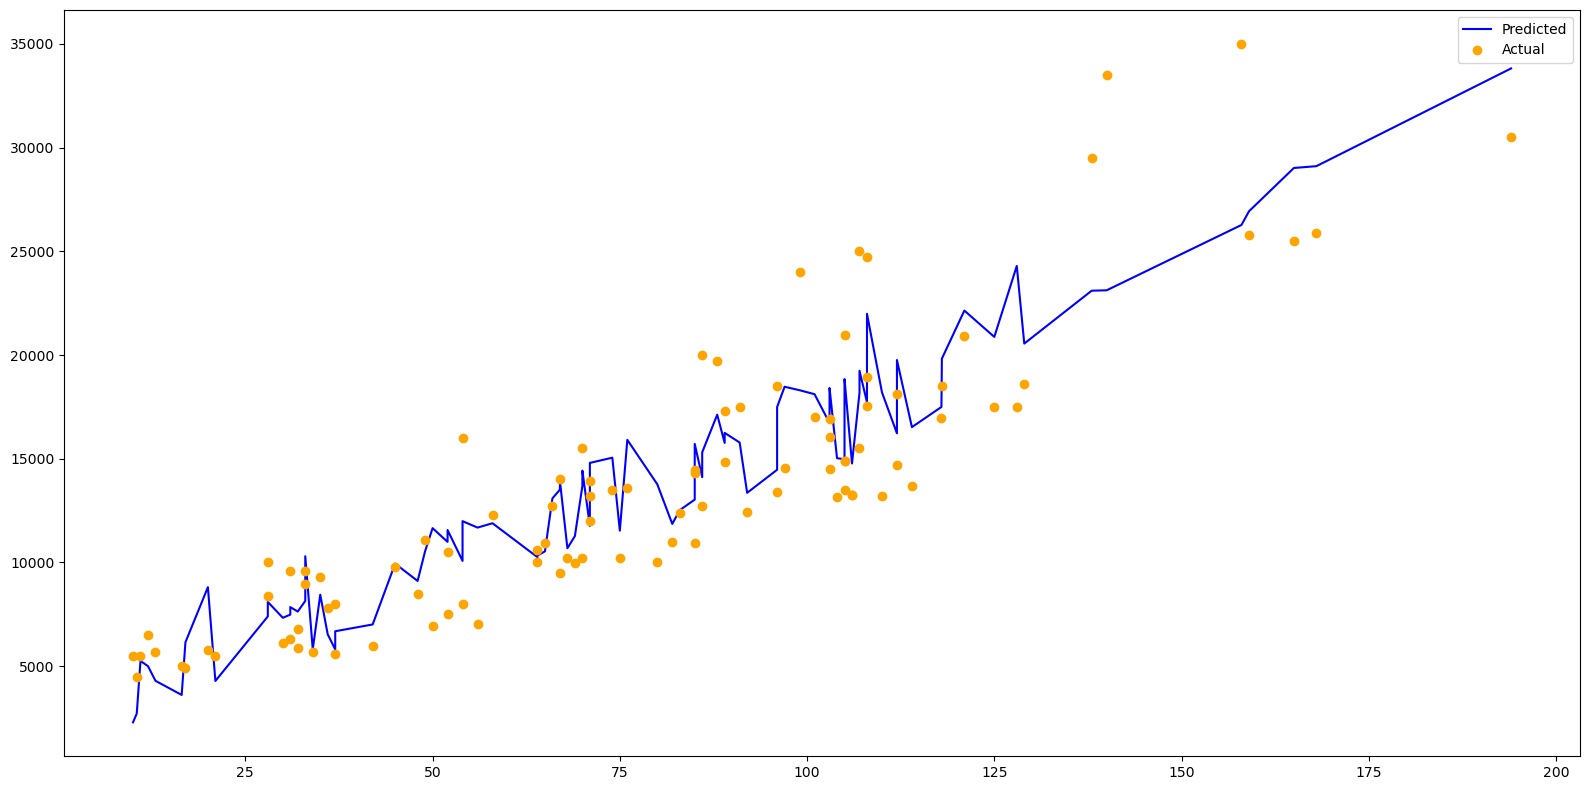

In [177]:
# We let the model above to predict multiple values, we compute the squared errors on these predictions and finally we plot
# both the original data and the predictions. It is evident that the there are plenty of fluctuations on the prediction line,
# indicating high chance of overfitting. However, if we focus on the prediction accuracy of the model on unseen data, this model
# provides a solid option.
out_of_sample(relation = ["Monthly_net_rent~Size+krpersq+C(City_Part)+C(Roomin)+C(Balcony)"], 
                            df = bolig_copy.loc[:,["Size","Monthly_net_rent", "City_Part", "krpersq", "Roomin", "Balcony"]], 
                            rnd_indx = range(100), a = 0.05, l = 0.001, plot = True, wls = False, ridge = True)


[<matplotlib.lines.Line2D object at 0x000001E85699F0D0>] [<matplotlib.lines.Line2D object at 0x000001E85699F370>] Legend None


[834113229.5065085]

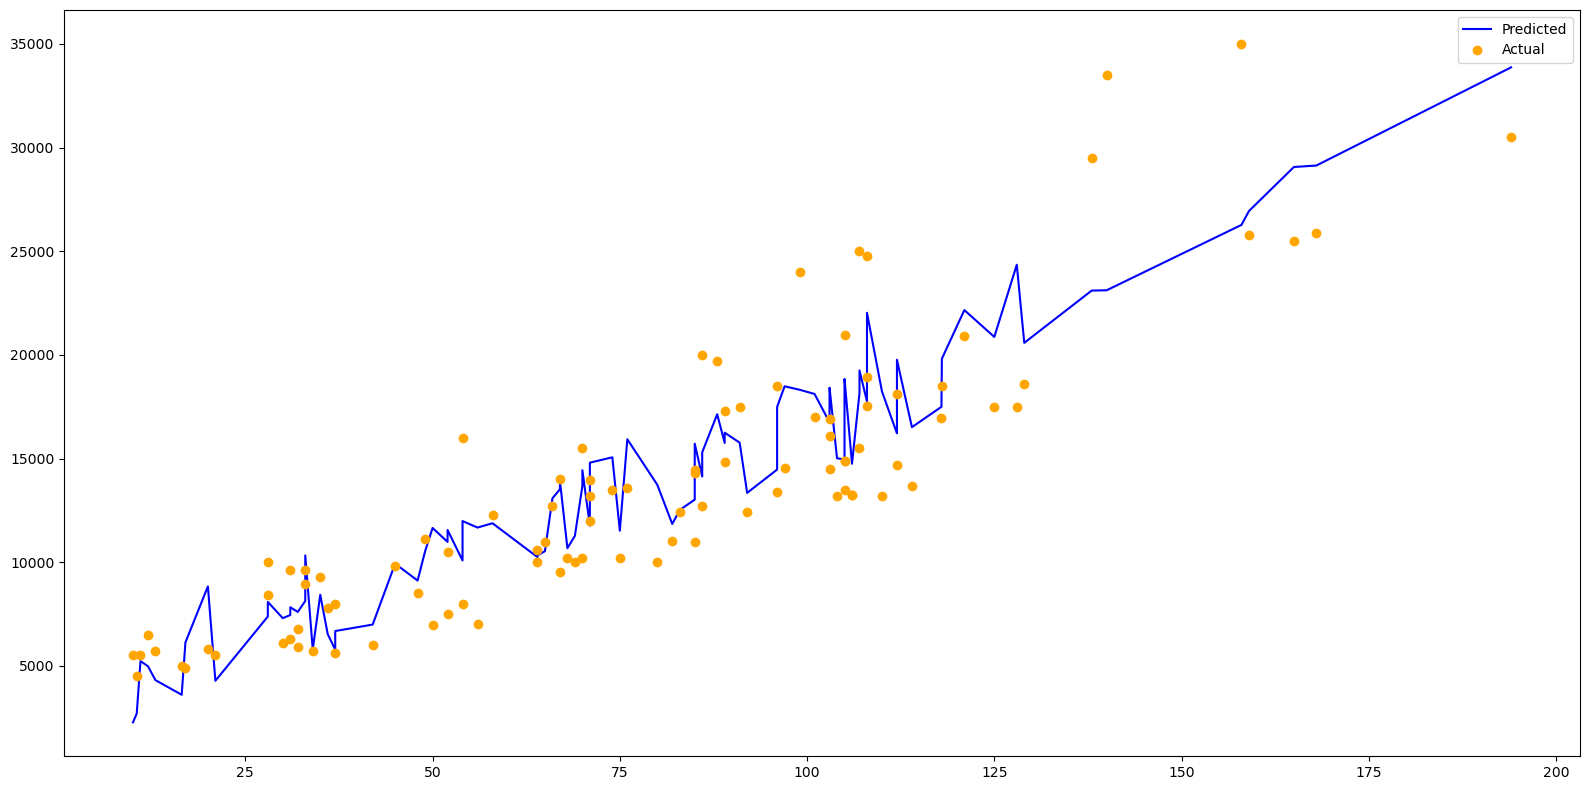

In [178]:
# Lets crate the same plot for the model without the Ridge parameter. We can clearly see that the prediction line is almost 
# identical, however the squared errors are still slightly smaller in the Ridge framework.
out_of_sample(relation = ["Monthly_net_rent~Size+krpersq+C(City_Part)+C(Roomin)+C(Balcony)"], 
                            df = bolig_copy.loc[:,["Size","Monthly_net_rent", "City_Part", "krpersq", "Roomin", "Balcony"]], 
                            rnd_indx = range(100), a = 0.05, l = 0, plot = True, wls = False, ridge = False)